<div class="alert alert-info">
<font size="4"><b>Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
    Привет, Сергей! Спасибо, что прислал задание :) <br>Меня зовут Никита Сон и я буду проверять твой проект. Предлагаю обращаться друг к другу на ты, как это принято в Практикуме, если ты не против. Но если хочешь на Вы - не буду возражать 🙂
        
Поехали 🚀
    <br />

Мои комментарии обозначены пометкой <b>Комментарий ревьюера</b>. При внесении правок в проект, пожалуйста, не меняй и не удаляй их т.к. дальнейшая проверка будет происходить в том числе на основе того, исправлены замечания в комментариях или нет. Зато ты всегда можешь оставить свои комментарии для меня :)
    </font>
</div>

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
В зелёных блоках будут позитивные комментарии
<br />
    </font>
</div>

<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
В жёлтых - некритичные замечания
    </font>
</div>

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
В красных - важные замечания, которые надо обязательно устранить
    </font>
</div>

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
В синих с пиццей - различные нейтральные сообщения, советы на будещее и прочее.
    </font>
</div>

In [4]:
! pip install sqlalchemy
! pip install shap
! pip install phik
! pip install missingno
! pip install optuna

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Молодец, что не забываешь устанавливать нужные либы. Часто это приходится "подчищать" за студентами по ревьюерской доброте

<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
А вот про фик забыл... Да и не только от него...

<div class="alert alert-info">
<font size="4"><b> Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
😅 да, слона я не заметил
    </font>
</div>

Цель: создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Важно:

- тип виновника — только машина (car);
- любым повреждениям транспортного средства, кроме типа SCRATCH (царапина);
- ограничиться данными за 2012 год — они самые свежие;
- учесть фактор возраста автомобиля.

# Импорты и константы

In [369]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import os
import requests
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
     fbeta_score,
     confusion_matrix,
     roc_auc_score,
     roc_curve,
     precision_recall_curve,
     PrecisionRecallDisplay,
     recall_score,
     precision_score
)
from scipy import stats as st
import missingno

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import *

from time import time

from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score
)
import shap
import optuna
from tqdm import tqdm

RANDOM_STATE = 1220

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Импорты сгруппированы по сабмодулям, из которых делаются импорты 👍

И задать сразу в константу на всю работу рандом стейт - отличный ход, по канонам хорошего кода

# Первичное исследование таблиц

In [6]:
def info_df(df):
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('-----------------------------------------')
    print('| Первые и последние 5 строчек датасета |')
    print('-----------------------------------------')
    display(df)
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    for i in df.select_dtypes(include='object').columns.to_list():
        print('--------------------------------------')
        print(f'| Уникальные значения признака {i} |')
        print('--------------------------------------')
        print(df[i].unique())


def view_distribution(data):
    interval_cols = data.select_dtypes(include='object').columns.to_list()
    fig, axes = plt.subplots(nrows=len(data[interval_cols].columns), ncols=2, figsize=(15, 15))
    j = 0
    for i in data[interval_cols].columns:
        sns.histplot(data[interval_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black', color=sns.color_palette("pink")[0])
        axes[j, 0].set_title(i, fontsize=14)
        axes[j, 0].set_xlabel('')

        sns.boxplot(x=data[interval_cols][i], ax=axes[j, 1], orient='h', palette="pink")
        axes[j, 1].set_title(i, fontsize=14)
        axes[j, 1].set_xlabel('')
        j += 1

    plt.suptitle(f'Признаки\n\n', ha='center', fontweight='bold', fontsize=20)
    plt.tight_layout()
    plt.show()


def phik_sign(data):
    interval_cols = data.select_dtypes(exclude='object').columns.to_list()
    phik_overview = data.phik_matrix(interval_cols=interval_cols)

    plt.figure(figsize=(10, 10))
    plt.title(r'Корреляция $\phi_K$')
    corr = phik_overview.round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

    significance_overview  = data.significance_matrix(interval_cols=interval_cols)

    plt.figure(figsize=(10, 10))
    plt.title('Статистическая значимость')
    corr = significance_overview.round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=5, vmin=-5, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Молодец, что оформил код в виде функций. Это правильный подход, повышающий простоту использования и поддержки кода.

In [7]:

db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string)

**Таблица parties**

In [10]:
sql_parties = """
SELECT  *
FROM parties
"""

info_df(pd.read_sql_query(sql_parties, con=engine, index_col='id'))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 2752408 entries, 22 to 2403844
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   case_id              object 
 1   party_number         int64  
 2   party_type           object 
 3   at_fault             int64  
 4   insurance_premium    float64
 5   party_sobriety       object 
 6   party_drug_physical  object 
 7   cellphone_in_use     float64
dtypes: float64(2), int64(2), object(4)
memory usage: 189.0+ MB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
id,,,,,,,,
22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
29,3899462,2,car,0,21.0,had not been drinking,None,0.0
31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
...,...,...,...,...,...,...,...,...
1549682,4981212,2,building,0,22.0,had not been drinking,None,NaN
1644472,5041069,2,building,0,13.0,had not been drinking,None,0.0
1906386,5181692,1,building,1,5.0,had not been drinking,None,0.0


--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака case_id |
--------------------------------------
['3899454' '3899462' '3899465' ... '5456653' '5456655' '4770406']
--------------------------------------
| Уникальные значения признака party_type |
--------------------------------------
['road signs' 'car' 'road bumper' None 'building' 'other']
--------------------------------------
| Уникальные значения признака party_sobriety |
--------------------------------------
['had not been drinking' 'not applicable' 'impairment unknown' None
 'had been drinking, not under influence'
 'had been drinking, under influence'
 'had been drinking, impairment unknown']
--------------------------------------
| Уникальные значения признака party_drug_physical |
--------------------------------------
[None 'not applicable' 'G' 'under drug influence' 'sleepy/fatigued'
 'impairment - physical']


<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
        <b></b>

Для <i>первичного</i> исследования табличек полностью выгружать их из базы не стоит - слишком много оперативной памяти расходуется впустую. Достаточно с помощью `limit` выгрузить ограниченную часть.

<div class="alert alert-info">
<font size="4"><b> Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Да, я изначально ставил лимит, но потом посчитал, что мне бы хотелось видить всю картину по пропускам и уникальным значениям. К тому же я не присваиваю табличку переменной, так что после того как функция отрабатывает память освобождается, хотя это конечно проблема когда таблица приходит с сервера. Конечно для уникальных значений и колличества пропусков я наверное мог воспользоваться SQL запросом, как вариант таким:

SELECT DISTINCT(Каждого признака)
FROM parties

Но посчитал, что с помощю Python будет оптимальнее.
    </font>
</div>

In [11]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_parties, con=engine, index_col='id')
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
case_id,0.000000
party_number,0.000000
party_type,0.100000
at_fault,0.000000
insurance_premium,14.700000
party_sobriety,2.700000
party_drug_physical,84.300000
cellphone_in_use,18.600000


| Описание                                                     | Обозначение в таблице | Подробнее                                                    |
|:------------------------------------------------------------ |:--------------------- |:------------------------------------------------------------ |
| Идентификационный номер                                      | ID                    | Уникальный идентификатор                                                                          |
| Идентификационный номер в базе данных                        | CASE_ID               | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Номер участника происшествия                                 | PARTY_NUMBER          | От 1 до N — по числу участников происшествия                 |
| Тип участника происшествия                                   | PARTY_TYPE            | 1 — Car (Авто)<br />2 — Road bumper (Дорожные знаки)<br />3 — Building (Строения)<br />4 — Road signs (Отбойник)<br />5 — Other (Другое)<br />6 — Operator (Оператор)<br />- — Not Stated (Не указано) |
| Виновность участника                                         | AT_FAULT              | 0/1                                                          |
| Сумма страховки (тыс. $)                                     | INSURANCE_PREMIUM     | число                                                        |
| Состояние участника: физическое или с учётом принятых лекарств | PARTY_DRUG_PHYSICAL   | E — Under Drug Influence (Под воздействием лекарств)<br />F — Impairment — Physical (Ухудшение состояния)<br />G — Impairment Unknown (Не известно)<br />H — Not Applicable (Не оценивался)<br />I — Sleepy/Fatigued (Сонный/Усталый)<br />- — Not Stated (Не указано) |
| Трезвость участника                                          | PARTY_SOBRIETY        | A — Had Not Been Drinking (Не пил)<br />B — Had Been Drinking, Under Influence (Был пьян, под влиянием)<br />C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)<br />D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)<br />G — Impairment Unknown (Неизвестно ухудшение)<br />H — Not Applicable (Не оценивался)<br />- — Not Stated (Не указано) |
| Наличие телефона в автомобиле (возможности разговаривать по громкой связи) | CELLPHONE_IN_USE      | 0/1                                                          |

В таблице `parties` есть несоответсвие данных, те данные которые должны быть записаны как целые числа или в виде буквенных обозначений, записаны в полном пояснении, при этом не все варианты есть, и существует большое количество пропусков данных особенно в физическом состоянии участника проишествия

**Таблица collisions**

In [13]:
sql_collisions = """
SELECT *
FROM collisions
"""

info_df(pd.read_sql_query(sql_collisions, con=engine, index_col='case_id'))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1400000 entries, 4083072 to 4083051
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   county_city_location         1400000 non-null  object 
 1   county_location              1400000 non-null  object 
 2   distance                     1400000 non-null  float64
 3   direction                    1059358 non-null  object 
 4   intersection                 1387781 non-null  float64
 5   weather_1                    1392741 non-null  object 
 6   location_type                518779 non-null   object 
 7   collision_damage             1400000 non-null  object 
 8   party_count                  1400000 non-null  int64  
 9   primary_collision_factor     1391834 non-null  object 
 10  pcf_violation_category       1372046 non-null  object 
 11  type_of_

,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
case_id,,,,,,,,,,,,,,,,,,,
4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082805,1502,kern,57.0,east,0.0,clear,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with no street lights,none,2009-01-17,21:04:00
4082820,1953,los angeles,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,functioning,2009-01-18,14:20:00
4082829,1502,kern,0.0,None,1.0,clear,highway,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2009-01-17,18:06:00


--------------------
| Сумма дубликатов |
--------------------
158
--------------------------------------
| Уникальные значения признака county_city_location |
--------------------------------------
['1942' '4313' '0109' '1950' '3004' '1500' '3307' '1975' '3300' '3315'
 '5690' '3305' '1971' '3009' '1959' '3012' '1985' '4807' '3801' '3903'
 '1000' '3003' '0112' '3000' '5000' '0105' '3028' '5007' '3017' '4005'
 '4006' '3104' '3313' '5607' '5600' '0100' '5601' '3609' '1900' '1989'
 '3702' '1908' '4200' '1300' '4116' '3001' '0707' '4304' '1925' '0901'
 '1953' '0300' '4806' '3404' '0101' '4311' '5407' '4109' '4300' '0900'
 '5704' '4900' '4905' '4111' '4904' '2406' '4100' '4305' '3013' '3024'
 '3020' '3007' '2300' '4203' '1923' '2900' '2802' '2109' '3106' '3100'
 '5200' '3401' '1941' '3616' '5002' '4306' '4114' '3021' '3008' '3026'
 '3630' '0710' '0701' '3341' '0712' '0706' '3312' '0700' '4008' '3607'
 '4102' '1990' '5500' '1700' '1977' '0709' '1949' '3602' '1901' '1969'
 '1976' '4803' '3010

In [14]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_collisions, con=engine, index_col='case_id')
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
county_city_location,0.000000
county_location,0.000000
distance,0.000000
direction,24.300000
intersection,0.900000
weather_1,0.500000
location_type,62.900000
collision_damage,0.000000
party_count,0.000000
primary_collision_factor,0.600000


| Описание                                           | Обозначение в таблице       | Подробнее                                                    |
| :------------------------------------------------- | :-------------------------- | :----------------------------------------------------------- |
| Идентификационный Номер в базе данных              | CASE_ID                     | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Дата происшествия                                  | COLLISION_DATE              | Формат год/месяц/день                                        |
| Время происшествия                                 | COLLISION_TIME              | Формат: 24-часовой                                           |
| Является ли место происшествие перекрёстком        | INTERSECTION                | Y — Intersection (перекрёсток)<br />N — Not Intersection (не перекрёсток)<br />-- — Not stated (Не указано) |
| Погода                                             | WEATHER_1                   | A — Clear (Ясно)<br />B — Cloudy (Облачно)<br />C — Raining (Дождь)<br />D — Snowing (Снегопад)<br />E — Fog (Туман)<br />F — Other (Другое)<br />G — Wind (Ветер)<br />- — Not Stated (Не указано) |
| Серьёзность происшествия                           | COLLISION_DAMAGE            | 1 — FATAL ТС (Не подлежит восстановлению)<br />2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)<br />3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)<br />4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)<br />0 – SCRATCH (Царапина) |
| Основной фактор аварии                             | PRIMARY_COLL_FACTOR         | A — Code Violation (Нарушение правил ПДД)<br />B — Other Improper Driving (Другое неправильное вождение)<br />C — Other Than Driver (Кроме водителя)<br />D — Unknown (Неизвестно)<br />E — Fell Asleep (Заснул)<br />- — Not Stated (Не указано) |
| Состояние дороги                                   | ROAD_SURFACE                | A — Dry (Сухая)<br />B — Wet (Мокрая)<br />C — Snowy or Icy (Заснеженная или обледенелая)<br />D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.)<br />- — Not Stated (Не указано) |
| Освещение                                          | LIGHTING                    | A — Daylight (Дневной свет)<br />B — Dusk-Dawn (Сумерки-Рассвет)<br />C — Dark-Street Lights (Темно-Уличные фонари)<br />D — Dark-No Street Lights (Темно-Нет уличных фонарей)<br />E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают)<br />- — Not Stated (Не указано) |
| Номер географических районов, где произошло ДТП    | COUNTY_CITY_LOCATION        | число                                                        |
| Названия географических районов, где произошло ДТП | COUNTY_LOCATION             | список разных названий, категориальный тип данных            |
| Направление движения на перекрёстке                | DIRECTION                   | N — North (Север)<br />E — East (Восток)<br />S — South (Юг)<br />W — West (Запад)<br />- or blank — Not State (Не указано) |
| Расстояние от главной дороги (метры)               | DISTANCE                    | число                                                        |
| Тип дороги                                         | LOCATION_TYPE               | H — Highway (Шоссе)<br />I — Intersection (Перекрёсток)<br />R — Ramp (or Collector) (Рампа)<br />- or blank — Not State Highway (Не указано) |
| Количество участников                              | PARTY_COUNT                 | число                                                        |
| Категория нарушения                                | PCF_VIOLATION_CATEGORY      | 01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)<br />02 — Impeding Traffic (Препятствие движению транспорта)<br />03 — Unsafe Speed (Превышение скорости)<br />04 — Following Too Closely (Опасное сближение)<br />05 — Wrong Side of Road (Неправильная сторона дороги)<br />06 — Improper Passing (Неправильное движение)<br />07 — Unsafe Lane Change (Небезопасная смена полосы движения)<br />08 — Improper Turning (Неправильный поворот)<br />09 — Automobile Right of Way (Автомобильное право проезда)<br />10 — Pedestrian Right of Way (Пешеходное право проезда)<br />11 — Pedestrian Violation (Нарушение пешеходами)<br />12 — Traffic Signals and Signs (Дорожные сигналы и знаки)<br />13 — Hazardous Parking (Неправильная парковка)<br />14 — Lights (Освещение)<br />15 — Brakes (Тормоза)<br />16 — Other Equipment (Другое оборудование)<br />17 — Other Hazardous Violation (Другие нарушения)<br />18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)<br />19 — Speeding (Скорость)<br />20 — Pedestrian dui (Нарушение пешехода)<br />21 — Unsafe Starting or Backing (Опасный старт)<br />22 — Other Improper Driving (Другое неправильное вождение)<br />23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)<br />24 — Fell Asleep (Заснул)<br />00 — Unknown (Неизвестно)<br />- — Not Stated (Не указано) |
| Тип аварии                                         | TYPE_OF_COLLISION           | A — Head-On (Лоб в лоб)<br />B — Sideswipe (Сторона)<br />C — Rear End (Столкновение задней частью)<br />D — Broadside (Боковой удар)<br />E — Hit Object (Удар объекта)<br />F — Overturned (Опрокинутый)<br />G — Vehicle (транспортное средство/ Пешеход)<br />H — Other (Другое)<br />- — Not Stated (Не указано) |
| Дополнительные участники ДТП                       | MOTOR_VEHICLE_INVOLVED_WITH | Other motor vehicle (Другой автомобиль)<br />Fixed object (Неподвижный объект)<br />Parked motor vehicle (Припаркованный автомобиль)<br />Pedestrian (Пешеход)<br />Parked motor vehicle (Припаркованный автомобиль)<br />Bicycle (Велосипедист)<br />Non-collision (Не столкновение)<br />Other object (Другой объект)<br />Motor vehicle on other roadway (Автомобиль на другой проезжей)<br />Animal (Животное)<br />Train (Поезд) |
| Дорожное состояние                                 | ROAD_CONDITION_1            | A — Holes, Deep Ruts (Ямы, глубокая колея)<br />B — Loose Material on Roadway (Сыпучий материал на проезжей части)<br />C — Obstruction on Roadway (Препятствие на проезжей части)<br />D — Construction or Repair Zone (Зона строительства или ремонта)<br />E — Reduced Roadway Width (Уменьшенная ширина проезжей части)<br />F — Flooded (Затоплено)<br />G — Other (Другое)<br />H — No Unusual Condition (Нет ничего необычного)<br />- — Not Stated (Не указано) |
| Устройство управления                              | control_device              | A — Functioning (Функционирует)<br />B — Not Functioning (Не функционирует)<br />C — Obscured (Затемнённый)<br />D — None (Нет)<br />- — Not Stated (Не указано) |

Аналогичная ситуация как и прошлой таблице за исключением признака `motor_vehicle_involved_with`

**Таблица vehicles**

In [15]:
sql_vehicles = """
SELECT *
FROM vehicles
"""
info_df(pd.read_sql_query(sql_vehicles, con=engine, index_col='id'))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1021234 entries, 1175713 to 1175699
Data columns (total 5 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   case_id               1021234 non-null  object 
 1   party_number          1021234 non-null  int64  
 2   vehicle_type          1021234 non-null  object 
 3   vehicle_transmission  997575 non-null   object 
 4   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 46.7+ MB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
id,,,,,
1175713,5305032,2,sedan,manual,3.0
1,3858022,1,sedan,auto,3.0
1175712,5305030,1,sedan,auto,3.0
1175717,5305033,3,sedan,auto,5.0
1175722,5305034,2,sedan,auto,5.0
...,...,...,...,...,...
1175684,5304990,2,sedan,manual,6.0
1175686,5304993,2,sedan,manual,3.0
1175687,5304994,2,sedan,manual,3.0


--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака case_id |
--------------------------------------
['5305032' '3858022' '5305030' ... '5304994' '5305002' '5305007']
--------------------------------------
| Уникальные значения признака vehicle_type |
--------------------------------------
['sedan' 'hatchback' 'coupe' 'minivan' 'other']
--------------------------------------
| Уникальные значения признака vehicle_transmission |
--------------------------------------
['manual' 'auto' None]


In [16]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_vehicles, con=engine, index_col='id')
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
case_id,0.000000
party_number,0.000000
vehicle_type,0.000000
vehicle_transmission,2.300000
vehicle_age,2.400000


| Описание                              | Обозначение в таблице | Подробнее                                                    |
| :------------------------------------ | :-------------------- | :----------------------------------------------------------- |
| Индекс текущей таблицы                | ID                    | Номер в таблице                                              |
| Идентификационный номер в базе данных | CASE_ID               | Уникальный номер для зарегистрированного происшествия в таблице происшествий. |
| Тип кузова                            | VEHICLE_TYPE          | MINIVAN<br />COUPE<br />SEDAN<br />HATCHBACK<br />OTHER      |
| Тип КПП                               | VEHICLE_TRANSMISSION  | auto (Автоматическая)<br />manual (Ручная)<br />- — Not Stated (Не указано) |
| Возраст автомобиля (в годах)          | VEHICLE_AGE           | число                                                        |

**Таблица case_ids**

In [17]:
sql_case_ids = """
SELECT *
FROM case_ids
"""
info_df(pd.read_sql_query(sql_case_ids, con=engine))

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
...,...,...
1399995,5668365,2021
1399996,5668366,2021
1399997,5668367,2021
1399998,5668368,2021


--------------------
| Сумма дубликатов |
--------------------
0
--------------------------------------
| Уникальные значения признака case_id |
--------------------------------------
['0081715' '0726202' '3858022' ... '5668367' '5668368' '5668369']
--------------------------------------
| Уникальные значения признака db_year |
--------------------------------------
['2021']


In [18]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(pd.read_sql_query(sql_case_ids, con=engine)
.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
case_id,0.000000
db_year,0.000000


Таблица отличается от того, как она описана на схеме данных. В ней 2 столбца:
- case_id - столбец с id проишествия
- db_year - столбец с годом

**Вывод**

Количество таблиц сопадает с заявленым, однако во всех таблицахимеются пропуски в данных и типы данных не соответсвуют заявленым. Связующая таблица case_ids не соответствовала завяленой архитектуре. Записи в таблицах `collisions` и `parties` несогласуются с описанием таблиц. Связующая таблица в столбце `db_year` содержит только одно уникальное значение 2021 года, что он означает не известно, но скорее всего это год создания схемы.

В данных содержится информация связанная исключительно с ДТП, но нет данных которые бы относились к благоприятной поездки, при обучении модель будет всегда смещаться в сторону ДТП из-за дисбаланса.

Общий ключ для всех таблиц - case_id

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Таблички просмотрены 👌

# Cтатистический анализ факторов ДТП

Посмотри на то в какие месяцы происходит наибольшее количество аварий, а также какой из сезонов был самым частым на ДТП.

In [45]:
sql_q_full = """
SELECT COUNT(case_id) AS collision,
        DATE_TRUNC('month', collision_date)::timestamp AS month
FROM collisions
GROUP BY month
"""
sql_q_before_2012 = """
WITH col AS (SELECT COUNT(case_id) AS collision,
                DATE_TRUNC('month', collision_date)::timestamp AS month,
                (CASE
                        WHEN EXTRACT(MONTH FROM collision_date) = 12 OR EXTRACT(MONTH FROM collision_date) BETWEEN 1 AND 2 THEN 'winter'
                        WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 3 AND 5 THEN 'spring'
                        WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 6 AND 8 THEN 'summer'
                        WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 9 AND 11 THEN 'autumn'
                END) AS season
        FROM collisions
        WHERE DATE_PART('year', collision_date) < 2012
        GROUP BY month, season)
SELECT  *,
        SUM(collision) OVER (PARTITION BY season) AS col_season
FROM col

"""

select = pd.read_sql_query(sql_q_full, con=engine, parse_dates='month')
select_b2012 = pd.read_sql_query(sql_q_before_2012, con=engine, parse_dates='month')

In [46]:
select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   collision  56 non-null     int64         
 1   month      56 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.0 KB


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


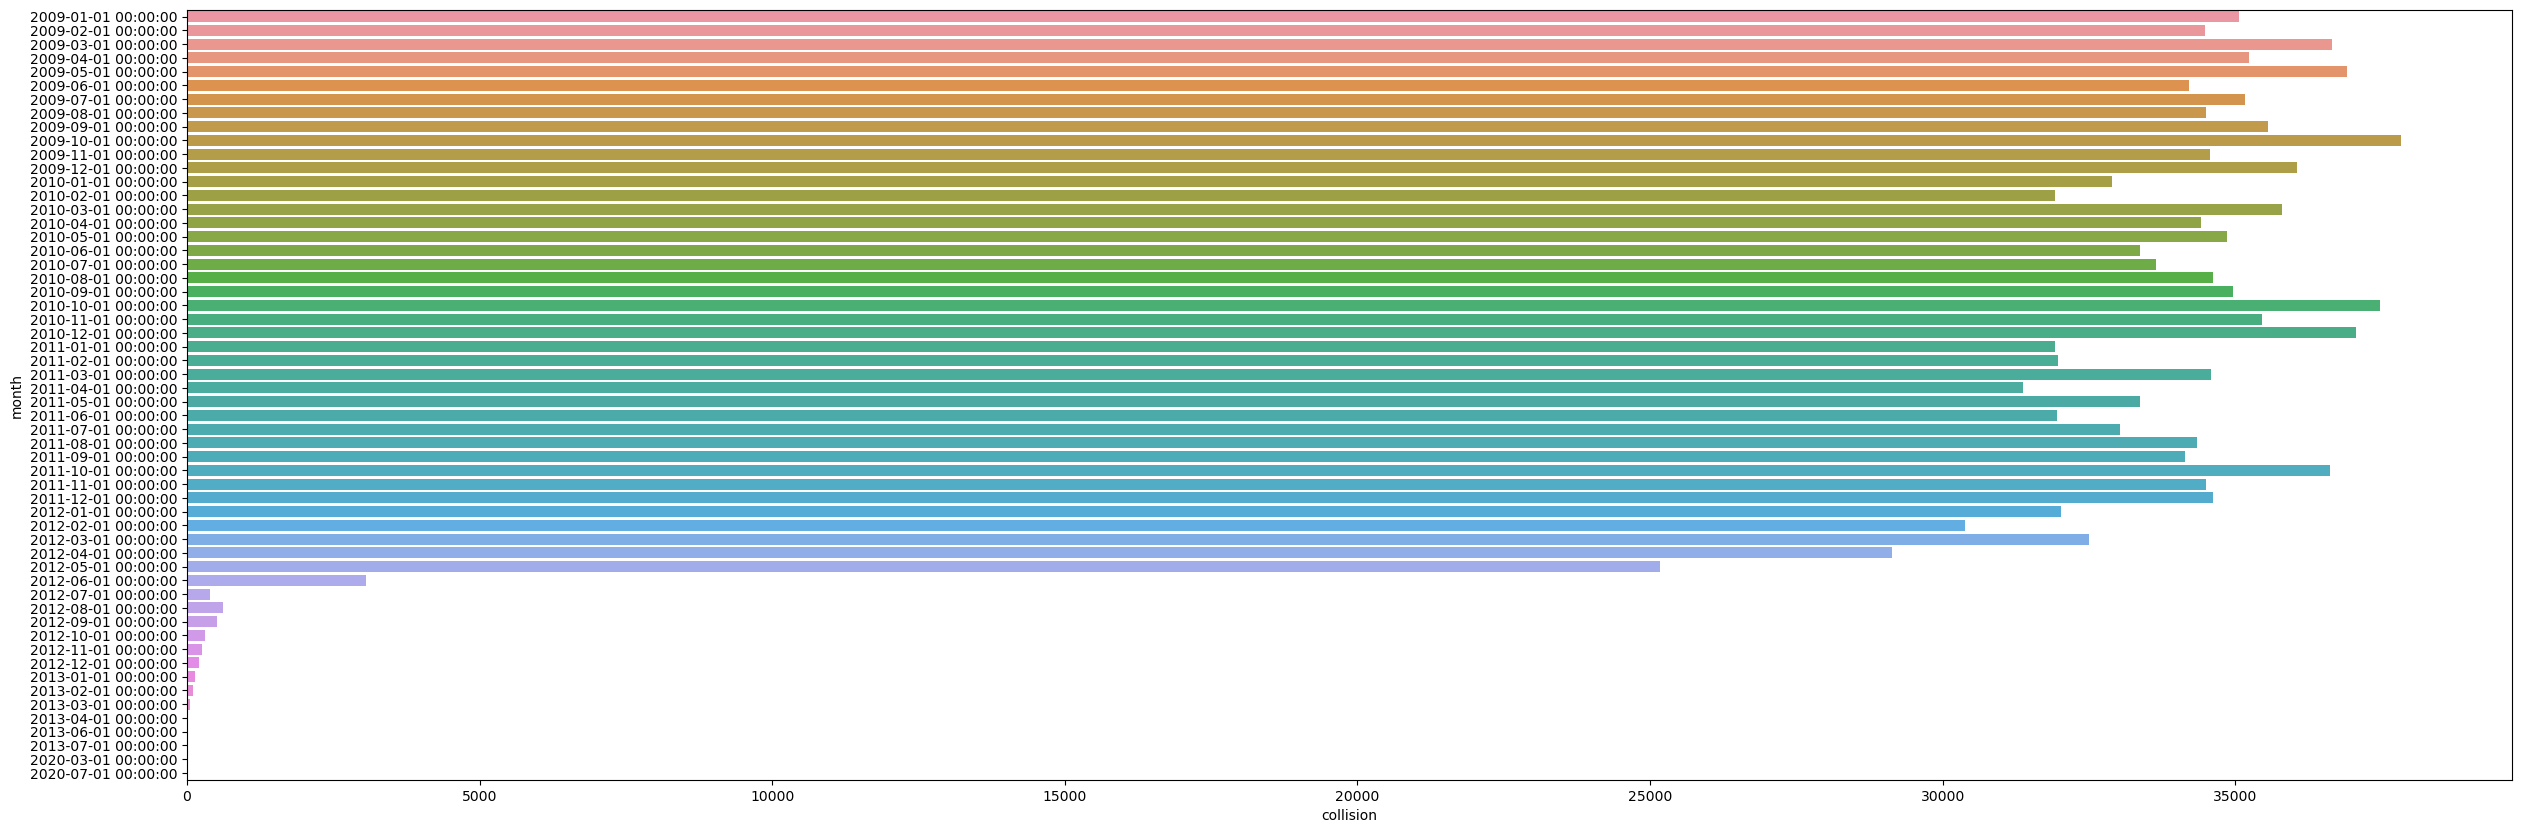

In [47]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=select, y='month', x='collision', ax=ax);

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
С одной стороны, ты, безусловно, молодец, что обнаружил, что посреди 2012 года очень резко падает число регистрируемых аварий, явно что-то произошло с поставкой данных.

На гистрограмме распределения видно, что начиная со второй половины 2012 года, данных становится сильно меньше, при этом существует разрыв начиная с 2013 года и до 2020. Ниже приведено распределение ДТП по временам года.

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


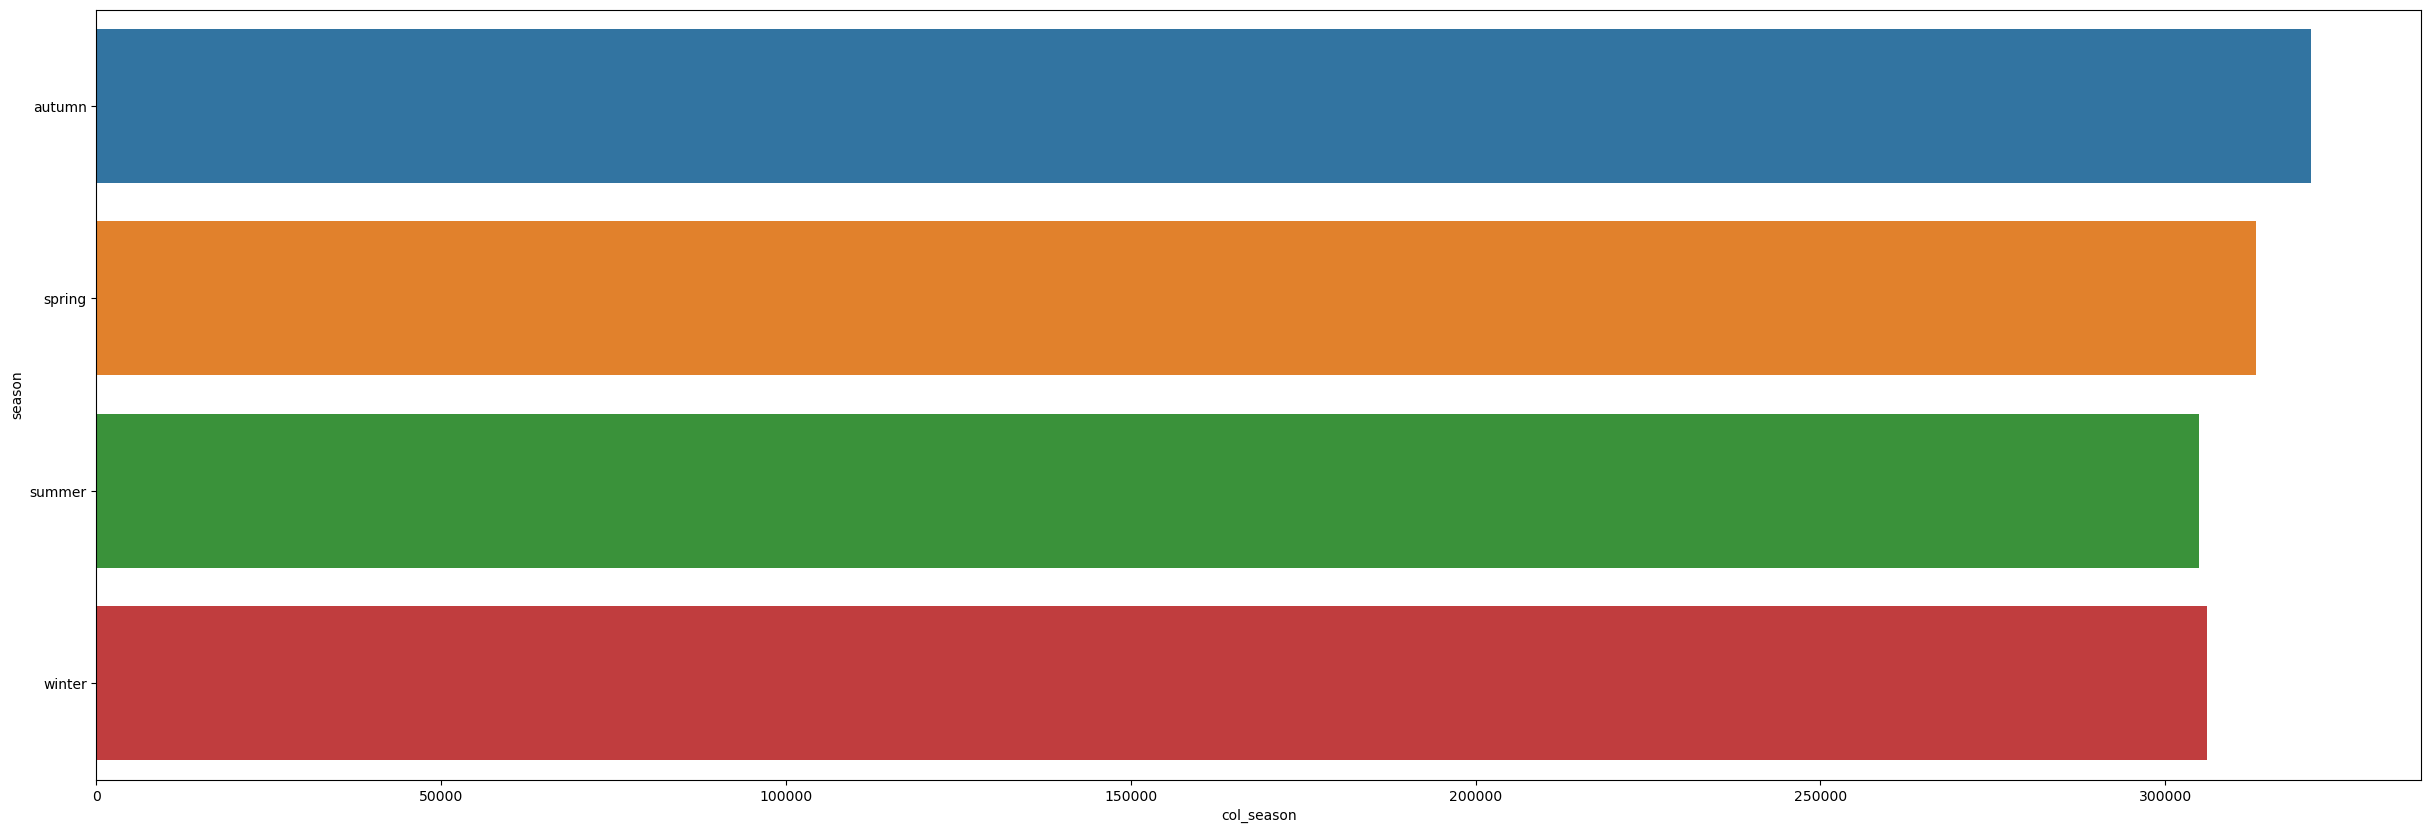

In [48]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=select_b2012, y='season', x='col_season', ax=ax);

Исключая данные позднее 2012 года включительно, так как информация по сравнению с прошлыми записями не сопоставима, можно предположить, что наиболее опасными сезонами является весна и осень, это можно связать с сильным изменением погодных условий, таких как: температура, давление, количество осадков, скорость ветра. Можно предположить, что все эти параметры влияют на дорожное покрытие и видимость для автомобилиста, что повишает риск ДТП, что и видно на гистрограмме.

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
А сразу же за этим ты делаешь абсурдный в условиях открытия выше вывод. Конечно аварий зимой и весной больше, чем летом и осенью, ведь за 2012 год мы получили информацию почти только о зимних и весенних авариях, а потом данные перестали поступать. Так что для этого исследования данные о 2012 годе надо исключить, оставить их только для моделирования, как то запросил заказчик.

<div class="alert alert-info">
<font size="4"><b> Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Исправил
    </font>
</div>

## Аналитические задачи

- Определить распределение участников проишествия по типу;
- Определить корреляцию между основным фактором аварии и суммой страховки;
- Существует ли зависимость параметров автомобиля с суммой страховки;
- Есть ли связь с состоянием дороги и временем года;
- Оценить взудите диссперсии параметров в таблице "информация о происшествиях", существуют ли линейно дублирующие параметры в таблице;
- Оценить серьезность ущерба в зависимости от трезвости водителя.

### Распределение участников проишествия по типу

Из первичного обзора данных стало ясно, что в таблице есть не соответствие типов данных, а также пропуски в них. Выполним преобразование типов данных, для оптимизации потребления оперативной памяти и дальнейшей работы с данными.

In [49]:
sql_parties = """
SELECT *
FROM parties
"""

df = pd.read_sql_query(sql_parties, con=engine, index_col='id')

In [50]:
group_party_type = df.groupby('party_type')[['at_fault']].agg(['count'])

,at_fault
,count
party_type,
building,48649
car,2469314
other,8879
road bumper,173488
road signs,48456


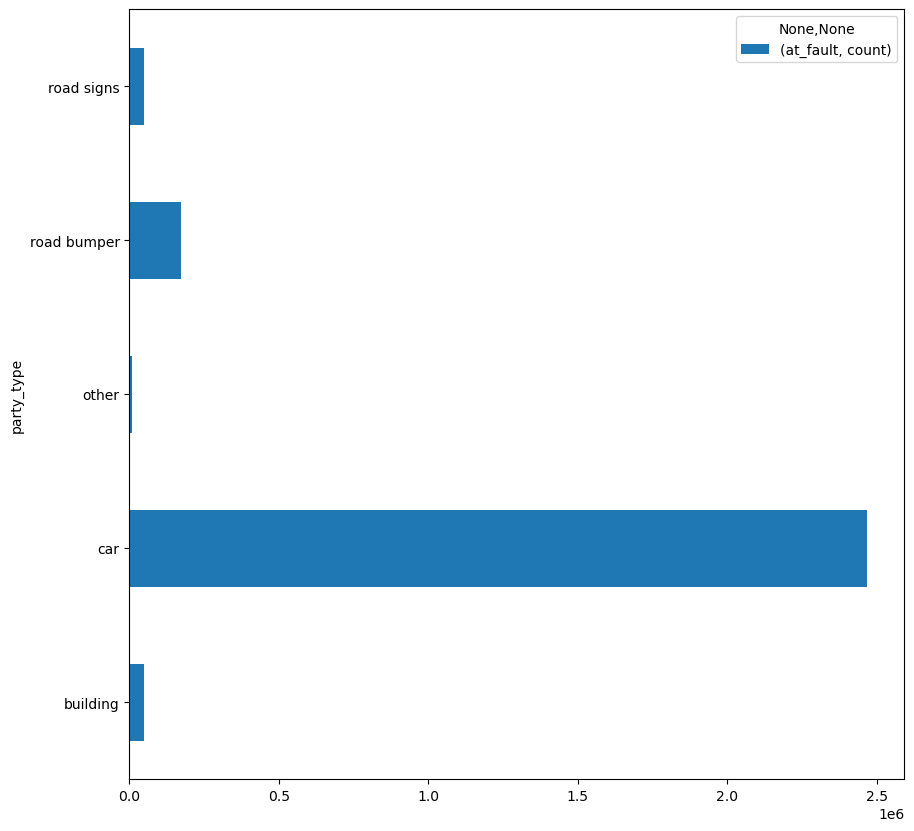

In [51]:
group_party_type.plot.barh(figsize=(10,10));
group_party_type

Наиболее частым участником проишествия является другой автомобиль, на втором месте дорожные знаки.

### Зависимость параметров автомобиля с суммой страховки

In [52]:
sql_parties = """
SELECT p.at_fault AS fault,
        p.insurance_premium AS insurance,
        v.vehicle_type AS v_type,
        v.vehicle_transmission AS v_transmission,
        v.vehicle_age AS age
FROM parties AS p
INNER JOIN vehicles AS v ON p.case_id = v.case_id
"""

df = pd.read_sql_query(sql_parties, con=engine)

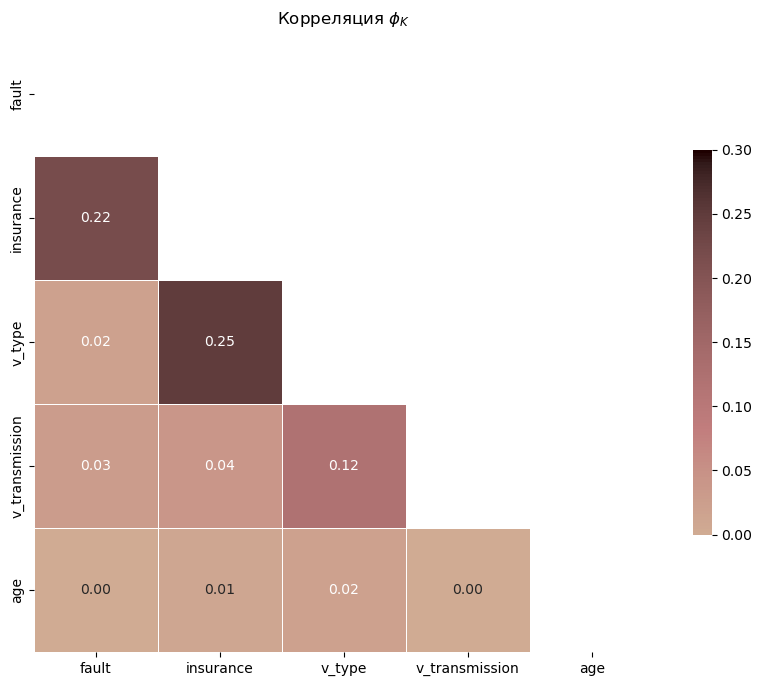

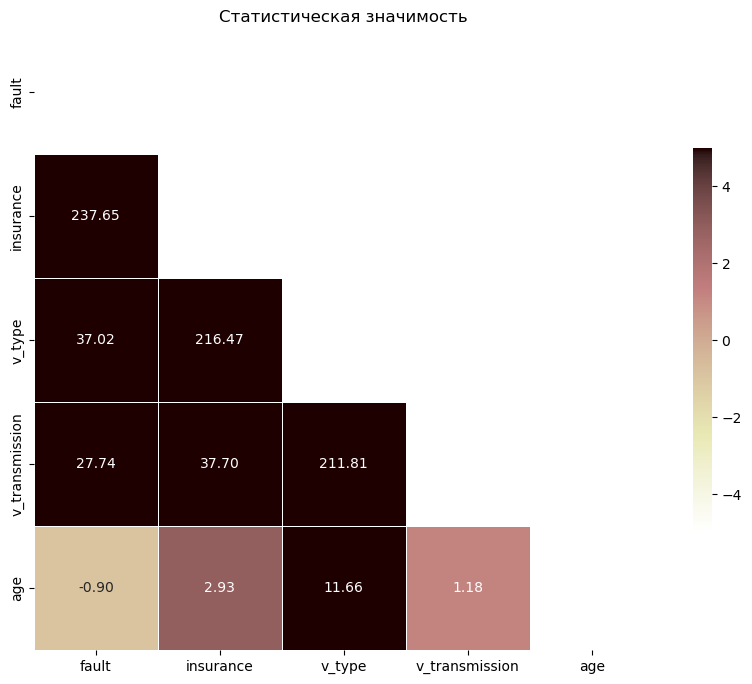

In [53]:
phik_sign(df)

Из анализа коррелляции и статистической значимости, можно сказать, что размер страховки не полностью, но в том числе зависит от типа кузова автомобиля, проверим есть ли зависимость между кузовом автомобиля, частотой его попадания в ДТП и размером страховки

In [54]:
sql_parties = """
WITH car AS (SELECT p.at_fault AS fault,
                    p.insurance_premium AS insurance,
                    v.vehicle_type AS v_type,
                    v.vehicle_transmission AS v_transmission,
                    v.vehicle_age AS age,
                    c.collision_date
            FROM parties AS p
            INNER JOIN vehicles AS v ON p.case_id = v.case_id
            INNER JOIN collisions AS c ON p.case_id = c.case_id)
SELECT fault,
        v_type,
        insurance,
        collision_date,
       COUNT(fault) OVER(PARTITION BY v_type) AS cnt_f,
       SUM(insurance) OVER(PARTITION BY v_type) AS sum_i
FROM car
"""

df = pd.read_sql_query(sql_parties, con=engine, parse_dates='collision_date')

<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Вообще говоря, ТЗ проекта говорит, что решение обеих задач, которые ты решаешь должно содержать связь 2 или более таблиц, а у тебя в первой задаче такого нет. Прощу и оставлю жёлтый, учитывая, что вторая разобранная тобой задача оказалась обширной и тебе пришлось писать 2 запроса, в обоих их которых связь нескольких табличек есть.
    </font>
</div>

In [55]:
df = df.drop_duplicates().reset_index(drop=True)
df = df.fillna(0)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451592 entries, 0 to 451591
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fault           451592 non-null  int64         
 1   v_type          451592 non-null  object        
 2   insurance       451592 non-null  float64       
 3   collision_date  451592 non-null  datetime64[ns]
 4   cnt_f           451592 non-null  int64         
 5   sum_i           451592 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 20.7+ MB


**Расспределение количества ДТП для каждого типа кузова**

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


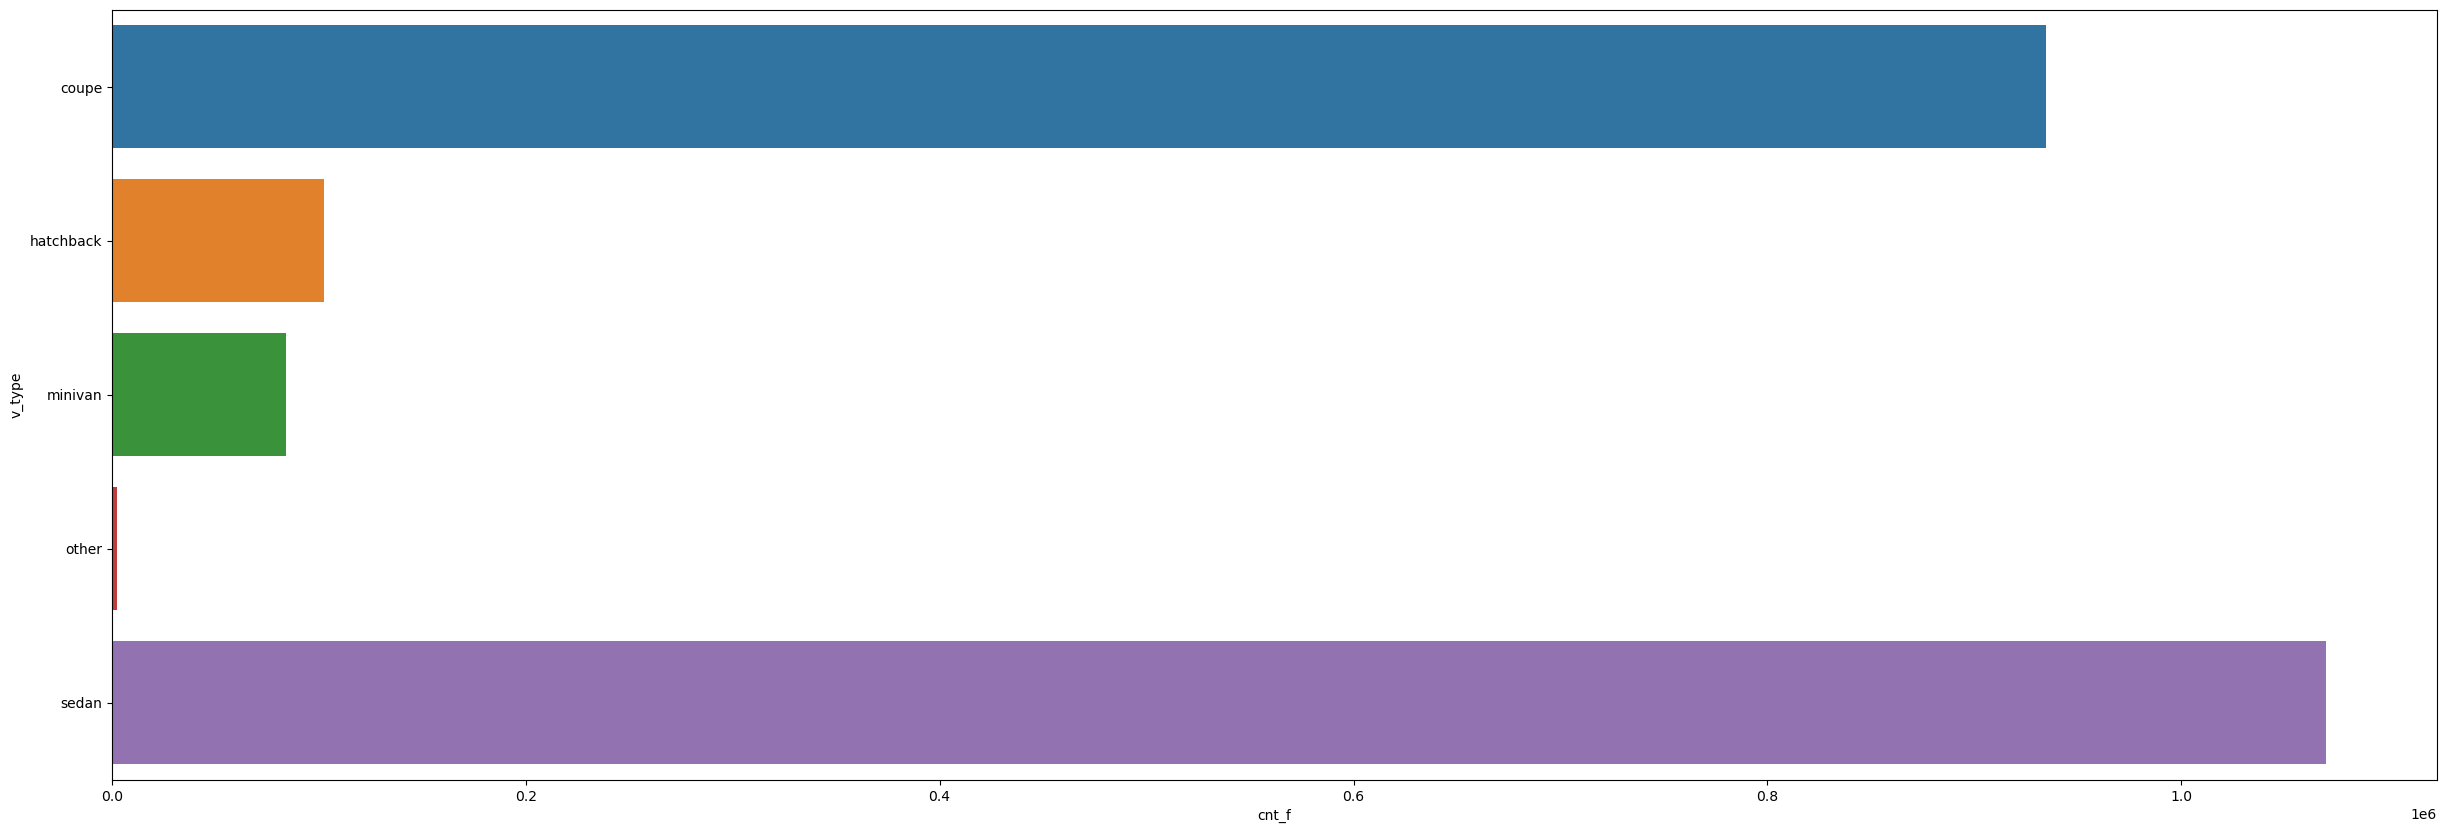

In [57]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=df, y='v_type', x='cnt_f', ax=ax);

**Расспределение суммы страховки и кузовом**

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


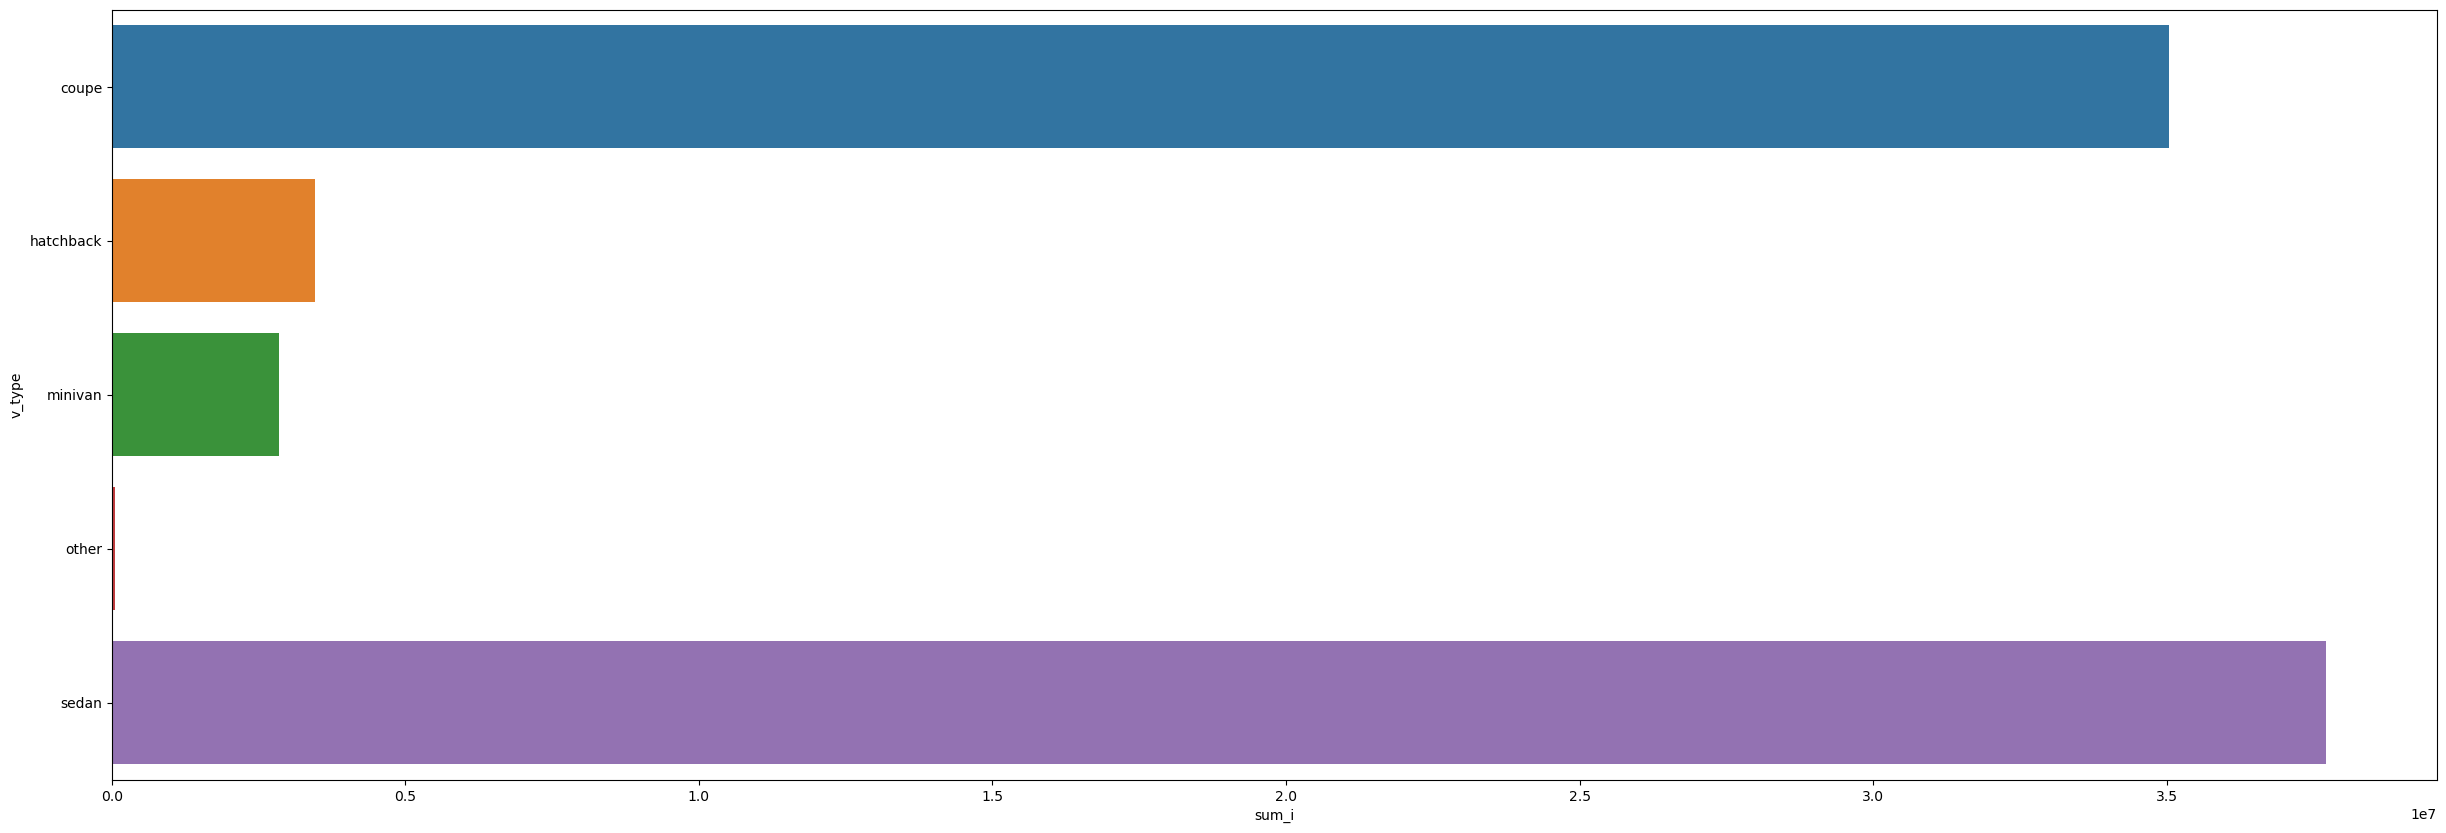

In [58]:
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=df, y='v_type', x='sum_i', ax=ax);

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


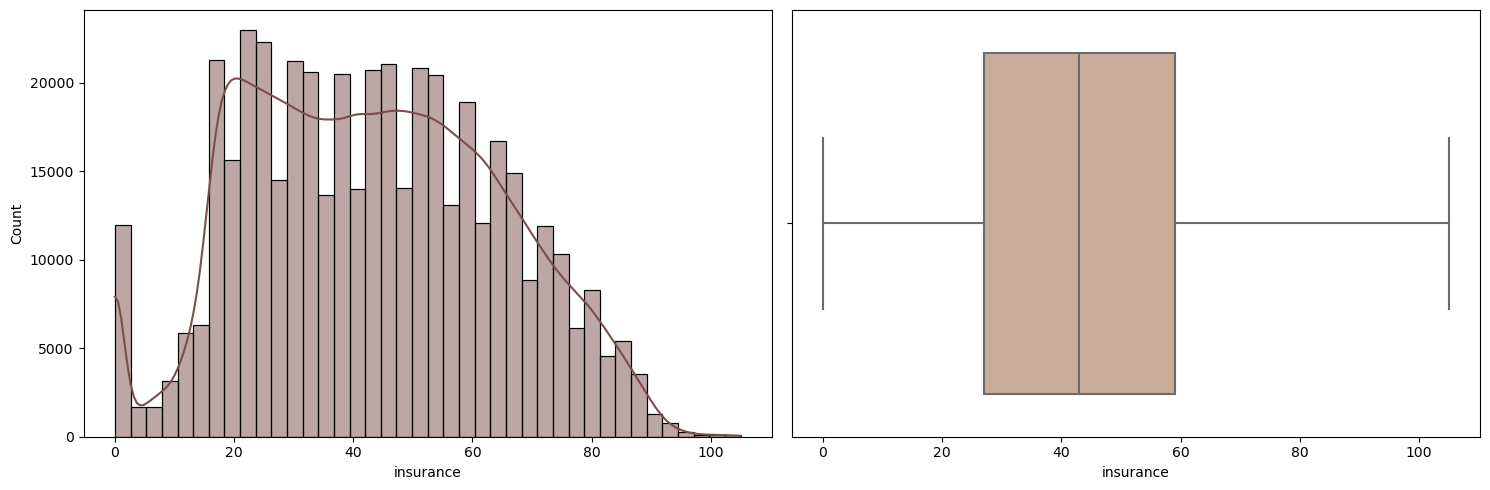

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['insurance'], ax=axes[0], kde=True, bins=40, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['insurance'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

По количеству аварий с лидирующие позиции занимают купе и седан они же имеют самые большие страховые взносы.

**Выводы**

- Наиболее опасными сезонами является весна и зима, это можно связать с сильным изменением погодных условий, таких как: температура, давление, количество осадков, скорость ветра. Можно предположить, что все эти параметры влияют на дорожное покрытие и видимость для автомобилиста, что повишает риск ДТП, что и видно на гистрограмме.

- Наиболее частым участником проишествия является другой автомобиль, на втором месте дорожные знаки.

- Из анализа коррелляции и статистической значимости, можно сказать, что размер страховки не полностью, но в том числе зависит от типа кузова автомобиля, анализ показал, что по количеству аварий лидирующие позиции занимают тип кузова купе и седан они же имеют самые большие страховые взносы.

# Оценка водительского риска и EDA

Подготовим данные согласно требованию заказчика.

- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.

Также добавим новый столбец указывающий на время года в которое было совершено ДТП и время суток основанное на значениях времени.

<Axes: >

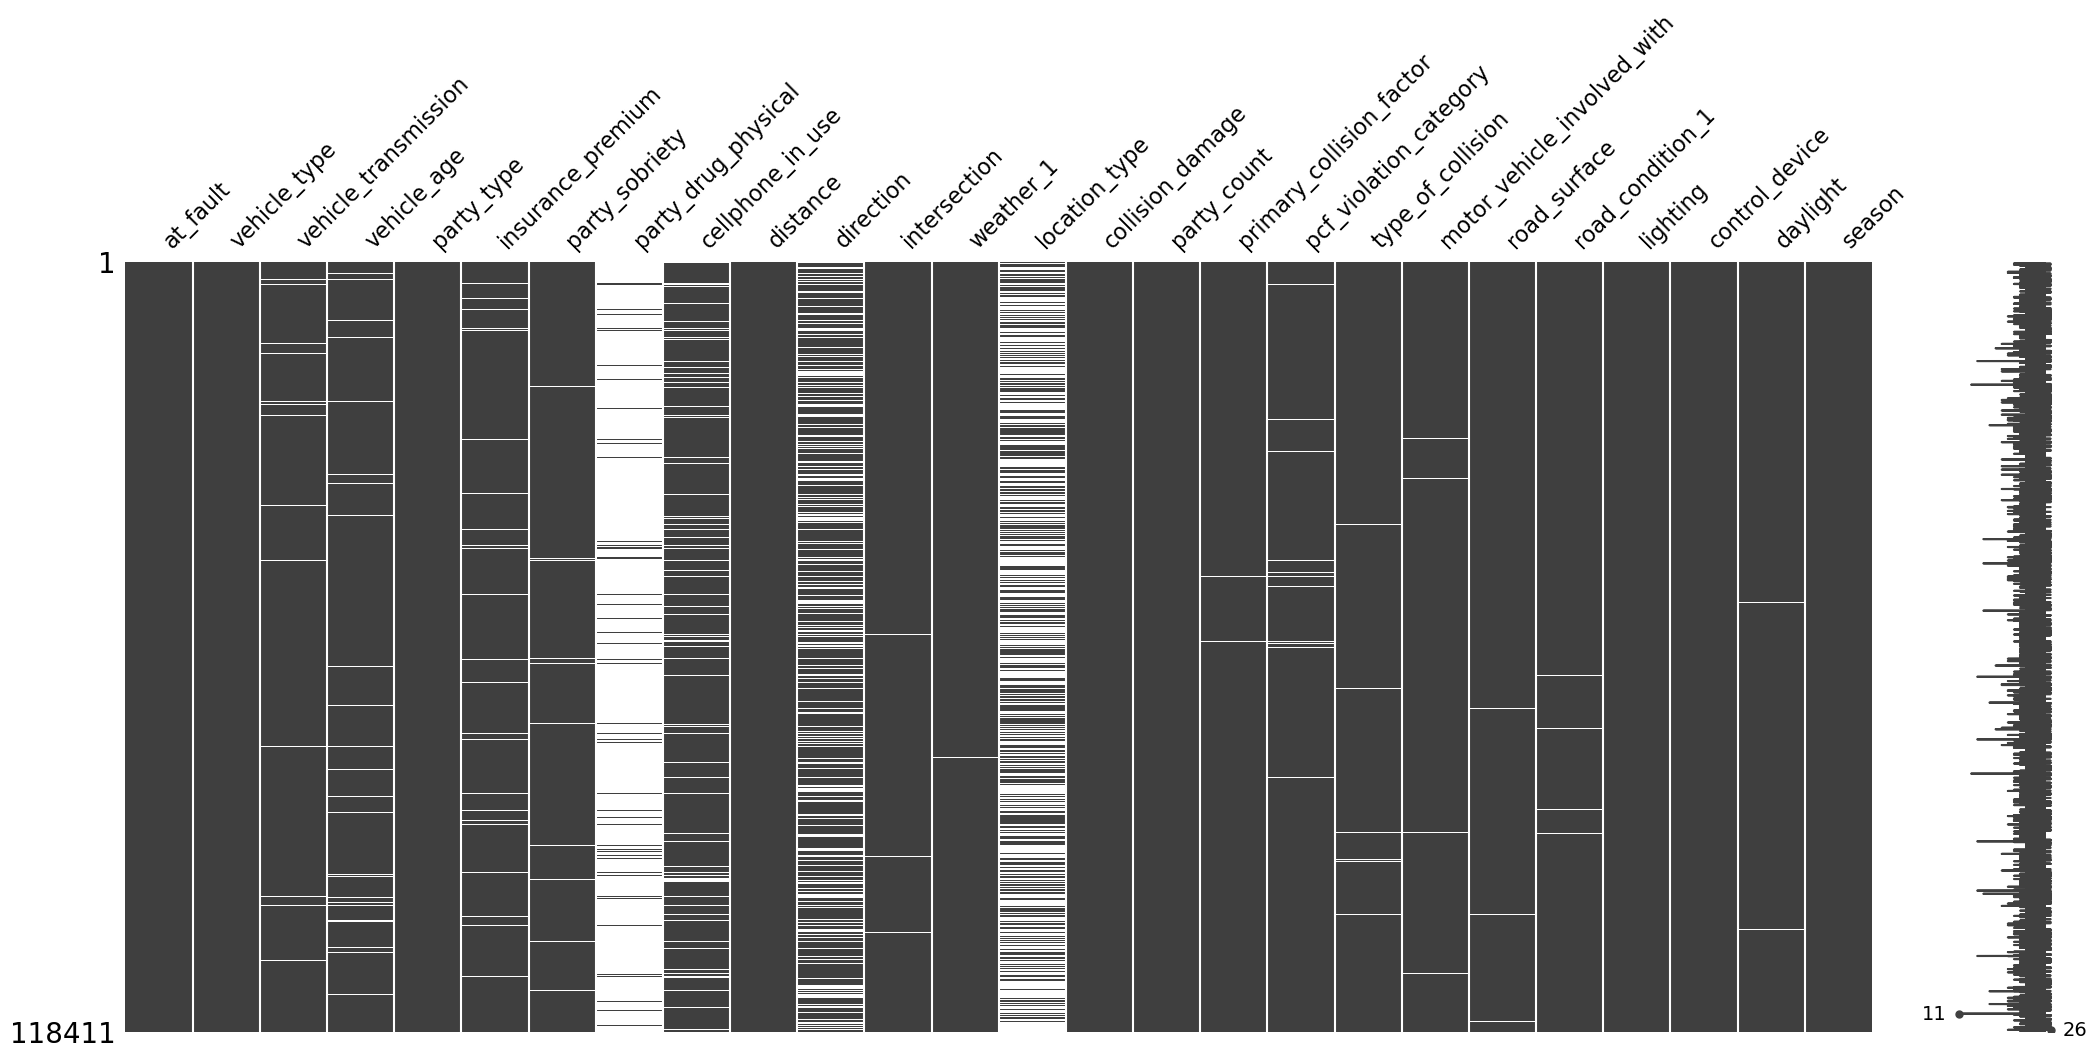

In [60]:
sql_query = '''
SELECT  at_fault,
		vehicle_type,
        vehicle_transmission,
        vehicle_age,
        party_type,
        insurance_premium,
        party_sobriety,
        party_drug_physical,
        cellphone_in_use,
        distance,
        direction,
        intersection,
        weather_1,
        location_type,
        collision_damage,
        party_count,
        primary_collision_factor,
        pcf_violation_category,
        type_of_collision,
        motor_vehicle_involved_with,
        road_surface,
        road_condition_1,
        lighting,
        control_device,
        daylight,
        season
FROM ((SELECT *,
            (CASE
                WHEN EXTRACT(MONTH FROM collision_date) = 12 OR EXTRACT(MONTH FROM collision_date) BETWEEN 1 AND 2 THEN 'winter'
                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 3 AND 5 THEN 'spring'
                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 6 AND 8 THEN 'summer'
                WHEN EXTRACT(MONTH FROM collision_date) BETWEEN 9 AND 11 THEN 'autumn'
            END) AS season,
            (CASE
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 0 AND 6 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'night'
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 7 AND 12 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'morning'
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 13 AND 18 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'day'
                WHEN EXTRACT(HOUR FROM collision_time) BETWEEN 19 AND 23 AND EXTRACT(MINUTE FROM collision_time) BETWEEN 0 AND 59 THEN 'evening'
            END) AS daylight
	FROM collisions
	WHERE DATE_PART('year', collision_date) = 2012) AS c
	JOIN
	(SELECT *
	FROM parties
	WHERE party_type = 'car') AS p ON c.case_id = p.case_id
	JOIN
	(SELECT *
	FROM vehicles) AS v ON p.case_id = v.case_id)
WHERE collision_damage != 'scratch'
'''
#подключение к базе and p.party_number = v.party_number
df = pd.read_sql_query(sql_query, con=engine)
missingno.matrix(df)

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Все факторы, запрошенные заказчиком, отображены в запросе

In [61]:
info_df(df)

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   at_fault                     118411 non-null  int64  
 1   vehicle_type                 118411 non-null  object 
 2   vehicle_transmission         116545 non-null  object 
 3   vehicle_age                  115046 non-null  float64
 4   party_type                   118411 non-null  object 
 5   insurance_premium            113289 non-null  float64
 6   party_sobriety               116682 non-null  object 
 7   party_drug_physical          8695 non-null    object 
 8   cellphone_in_use             107507 non-null  float64
 9   distance                     118411 non-null  float64
 10  direction                    89466 non-null   object 
 11  intersection            

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
0,1,coupe,auto,13.0,car,86.0,had not been drinking,None,0.0,413.0,...,vehicle code violation,improper turning,hit object,fixed object,dry,normal,daylight,none,morning,winter
1,1,sedan,manual,0.0,car,19.0,had not been drinking,None,0.0,36.0,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,functioning,morning,winter
2,0,sedan,manual,0.0,car,26.0,had not been drinking,None,0.0,36.0,...,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,functioning,morning,winter
3,1,hatchback,auto,1.0,car,47.0,had not been drinking,None,0.0,162.0,...,vehicle code violation,None,other,other object,dry,normal,daylight,none,day,winter
4,1,sedan,auto,2.0,car,20.0,had not been drinking,None,0.0,150.0,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,dusk or dawn,functioning,day,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,0,coupe,manual,7.0,car,46.0,had not been drinking,None,0.0,570.0,...,vehicle code violation,improper turning,head-on,other motor vehicle,dry,normal,dark with no street lights,none,evening,winter
118407,0,coupe,manual,3.0,car,46.0,had not been drinking,None,0.0,570.0,...,vehicle code violation,improper turning,head-on,other motor vehicle,dry,normal,dark with no street lights,none,evening,winter
118408,1,sedan,auto,8.0,car,24.0,"had been drinking, under influence",None,NaN,0.0,...,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,night,winter
118409,0,sedan,auto,8.0,car,52.0,had not been drinking,None,NaN,0.0,...,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,night,winter


--------------------
| Сумма дубликатов |
--------------------
2556
--------------------------------------
| Уникальные значения признака vehicle_type |
--------------------------------------
['coupe' 'sedan' 'hatchback' 'minivan' 'other']
--------------------------------------
| Уникальные значения признака vehicle_transmission |
--------------------------------------
['auto' 'manual' None]
--------------------------------------
| Уникальные значения признака party_type |
--------------------------------------
['car']
--------------------------------------
| Уникальные значения признака party_sobriety |
--------------------------------------
['had not been drinking' 'impairment unknown'
 'had been drinking, not under influence' None
 'had been drinking, under influence'
 'had been drinking, impairment unknown' 'not applicable']
--------------------------------------
| Уникальные значения признака party_drug_physical |
--------------------------------------
[None 'G' 'sleepy/fatigued' 

In [62]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
(pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm'))

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
at_fault,0.000000
vehicle_type,0.000000
vehicle_transmission,1.600000
vehicle_age,2.800000
party_type,0.000000
insurance_premium,4.300000
party_sobriety,1.500000
party_drug_physical,92.700000
cellphone_in_use,9.200000
distance,0.000000


Из первичного анализа видно, что в данных существую пропуски и не явные дубликаты. Выполним исследовательский анализ данных для выбора признаков.

### vehicle_transmission

Можно предлополижить что разница в типе трансмиссии будет влиять на вероятность ДТП из-за неисправности.

Нулевая гипотеза звучит как: количество ДТП с механической КПП не отличается от автомобиля с автоматической КПП.

Альтернативная гипотеза: наличие механической коробки передач увеличивает количество ДТП.

Пропуски в данных заполнить не представляется возможным, так как тип кузова не может дать никакой информации о типе КПП, а другой технической информации о машине у нас нет. Процент пропуска от всего набора данных составляет 1.6% что не является серьезным значением, удалим пропуски.

In [63]:
df = df.loc[df['vehicle_transmission'].isna() == False]

In [64]:
# ДТП при РКПП
fault_manula = df.loc[df['vehicle_transmission'] == 'manual', 'at_fault']
# ДТП при АКПП
fault_auto = df.loc[df['vehicle_transmission'] == 'auto', 'at_fault']
# Уровень статистической значимости
alpha = .05

results = st.ttest_ind(fault_manula, fault_auto, alternative='greater')
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 4.2056519367994095e-19
Отвергаем нулевую гипотезу


Статестический тест показал, что тип коробки передач действительно влияет на количество аварий, скорее всего это свзязано с надежностью РКПП, оставим эти данные и преобразуем тип данных

In [65]:
df['vehicle_transmission'] = df['vehicle_transmission'].astype('category')

**Выбросы в данных**

Проверим данные на аномальные значения

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


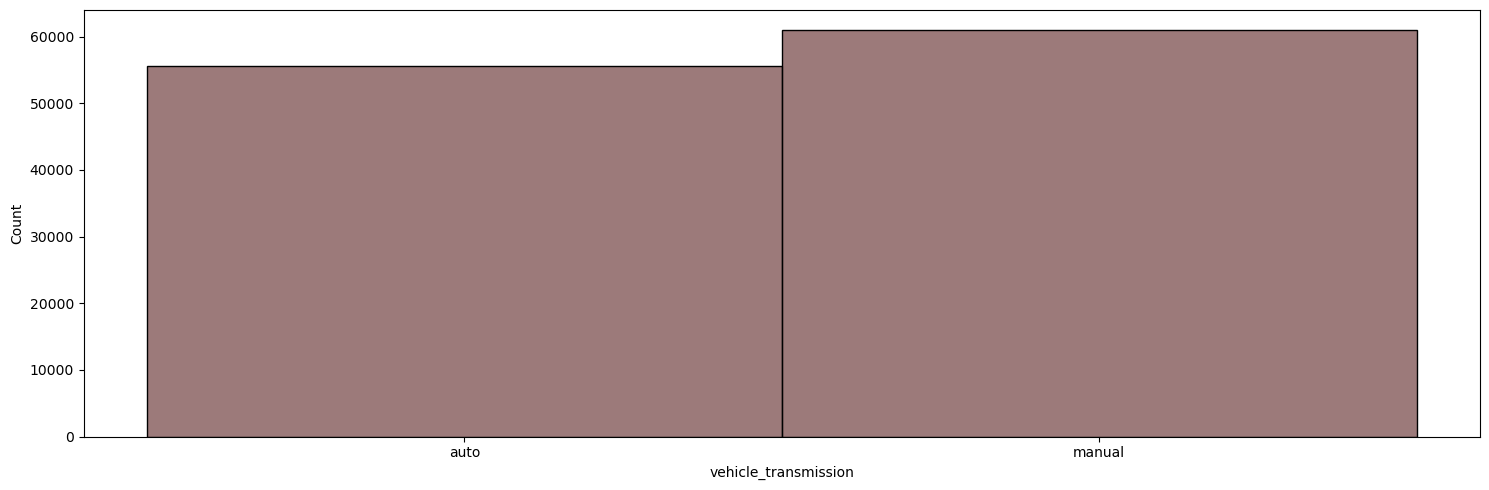

In [66]:
fig, axes = plt.subplots( figsize=(15, 5))
sns.histplot(df['vehicle_transmission'], bins=40, edgecolor='black', color=sns.color_palette("pink")[0])

plt.tight_layout()
plt.show()

Сильного дисбаланса нет

### vehicle_age

Основываясь на информации о известных суммах страховки для того или иного кузова авто, попробуем восстановить данные для пропущенных значений.

In [67]:
df.loc[df['vehicle_age'].isna() == True]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
238,1,sedan,auto,NaN,car,NaN,impairment unknown,G,0.0,500.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,winter
239,0,sedan,auto,NaN,car,78.0,had not been drinking,None,0.0,500.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,winter
244,0,sedan,manual,NaN,car,61.0,had not been drinking,None,0.0,0.0,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,dusk or dawn,functioning,day,winter
246,1,sedan,manual,NaN,car,54.0,had not been drinking,None,0.0,0.0,...,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,dusk or dawn,functioning,day,winter
303,1,sedan,manual,NaN,car,18.0,had not been drinking,None,0.0,150.0,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,obstruction,daylight,none,morning,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118173,0,sedan,auto,NaN,car,72.0,None,None,0.0,220.0,...,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,daylight,none,day,summer
118234,1,sedan,manual,NaN,car,55.0,had not been drinking,None,0.0,2640.0,...,vehicle code violation,unsafe starting or backing,rear end,other motor vehicle,dry,normal,daylight,none,day,summer
118236,0,sedan,manual,NaN,car,37.0,had not been drinking,None,0.0,2640.0,...,vehicle code violation,unsafe starting or backing,rear end,other motor vehicle,dry,normal,daylight,none,day,summer
118309,1,sedan,manual,NaN,car,19.0,had not been drinking,None,0.0,371.0,...,vehicle code violation,improper turning,overturned,non-collision,dry,normal,daylight,none,morning,summer


In [68]:
(df.loc[df['vehicle_age'].isna() == False,
        ['insurance_premium', 'vehicle_type', 'vehicle_age']]
        .groupby('vehicle_type')[['insurance_premium', 'vehicle_age']]
        .agg({'median'}))

,insurance_premium,vehicle_age
,median,median
vehicle_type,,
coupe,37.0,5.0
hatchback,41.0,5.0
minivan,42.0,4.0
other,26.0,4.0
sedan,35.0,4.0


In [69]:
for v_type in df['vehicle_type'].unique():
    df.loc[(df['vehicle_type'] == v_type)
            & (df['vehicle_age'].isna() == True),'vehicle_age'] = \
    df.loc[(df['vehicle_type'] == v_type)
                   & (df['vehicle_age'].isna() == False),
                     'vehicle_age'].median()

**Выбросы в данных**

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


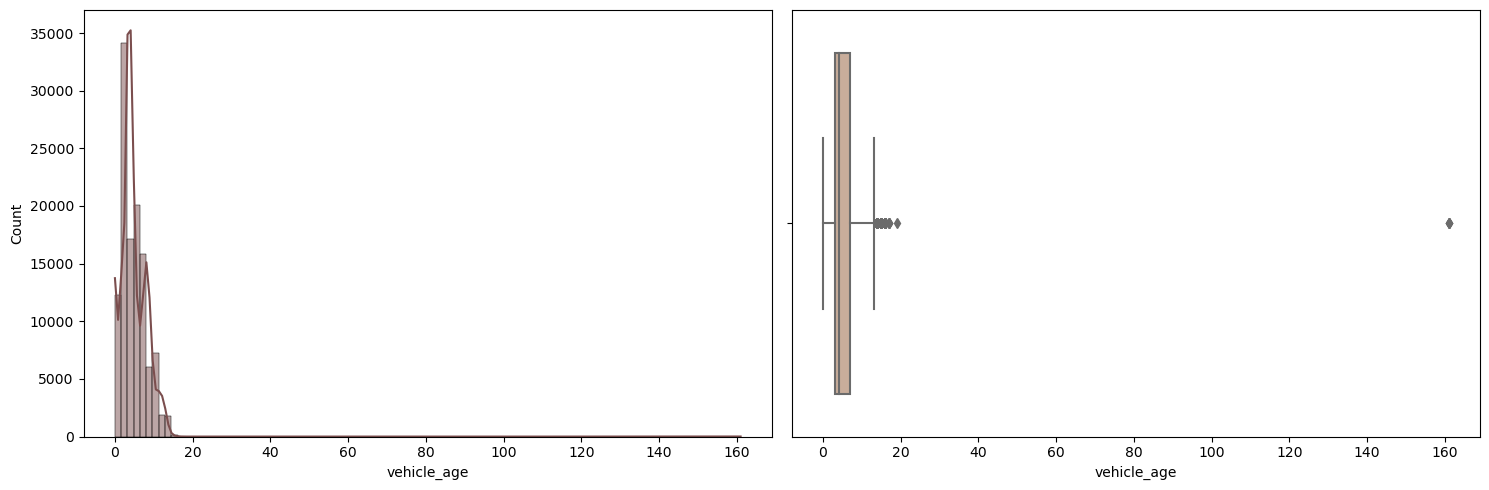

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['vehicle_age'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['vehicle_age'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

В признаке возраст авто присутсвуют аномальные значения в возрасте авто в 160 лет. Удалим эти данные

In [71]:
df = df.loc[df['vehicle_age'] <= 20]

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Да, вряд ли по Калифорнии гоняют 160-летние автомобили

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


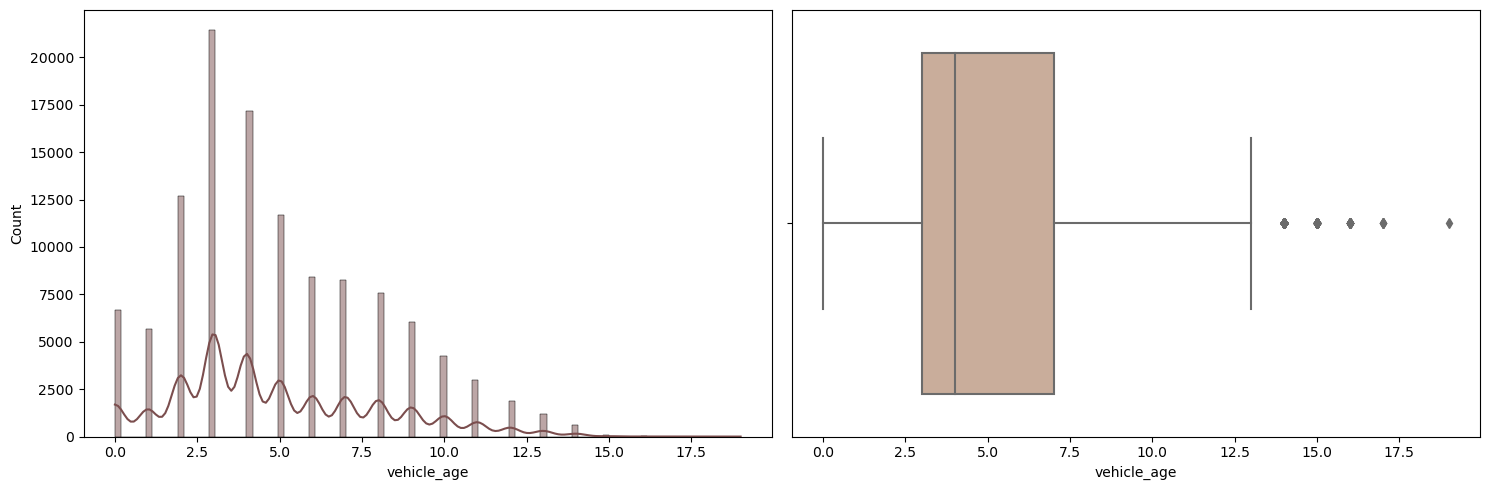

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['vehicle_age'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['vehicle_age'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [73]:
df['vehicle_age'] = df['vehicle_age'].astype('int8')

### insurance_premium

Проанализируем, какой из параметров больше влияет на стоимость страховки, тип кузова или возраст автомобиля.

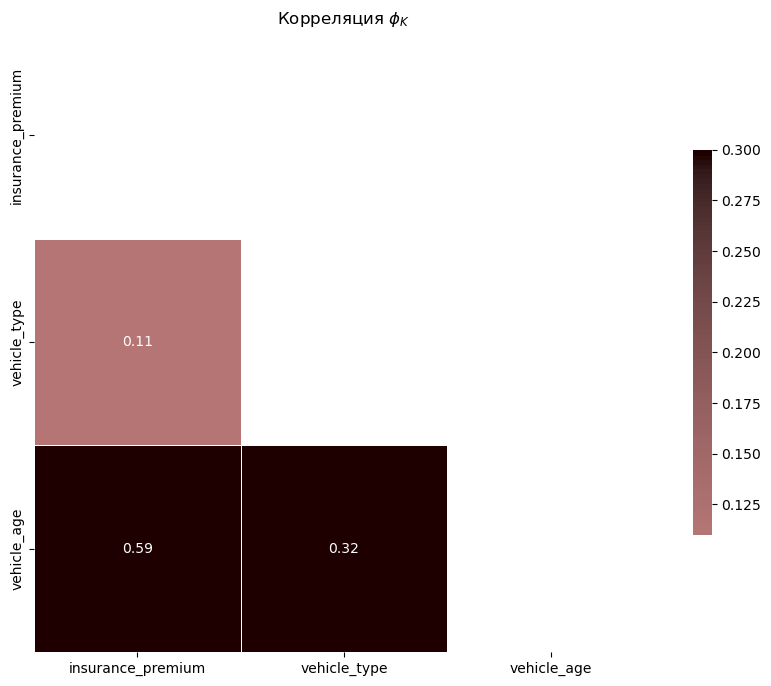

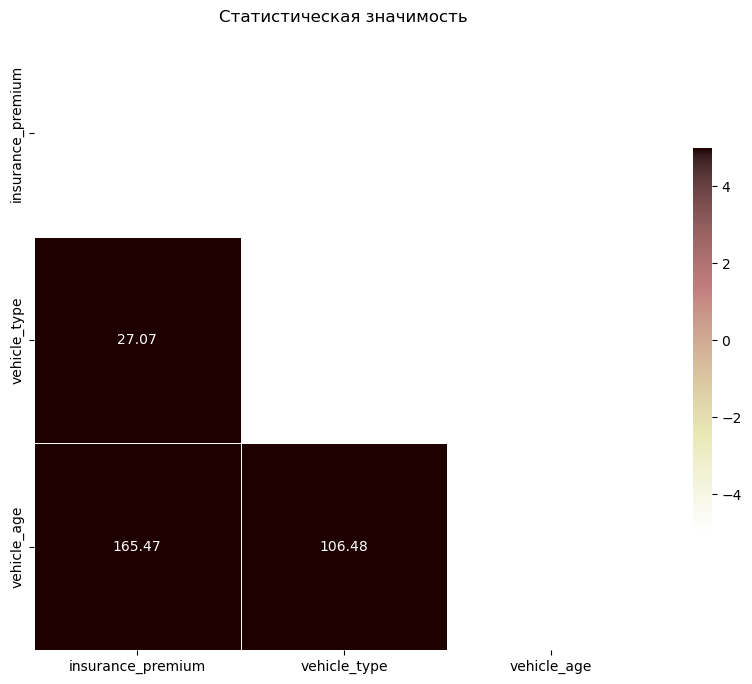

In [74]:
phik_sign(df.loc[df['insurance_premium'].isna() == False, ['insurance_premium', 'vehicle_type','vehicle_age']])

Из анализа корреляции и уровня статистической значимости, можно сказать, что тип возраст авто больше коррелирует с стоимостью страховки чем тип кузова.

In [75]:
df.loc[df['insurance_premium'].isna() == True]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
9,1,sedan,auto,3,car,NaN,impairment unknown,G,NaN,0.0,...,vehicle code violation,improper turning,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,day,winter
16,1,sedan,auto,3,car,NaN,impairment unknown,G,0.0,1.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,dark with no street lights,none,night,winter
28,1,sedan,auto,3,car,NaN,impairment unknown,G,0.0,1584.0,...,vehicle code violation,improper turning,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,winter
42,1,minivan,manual,7,car,NaN,impairment unknown,G,NaN,0.0,...,vehicle code violation,automobile right of way,broadside,bicycle,dry,normal,daylight,functioning,morning,spring
45,1,minivan,manual,5,car,NaN,impairment unknown,G,0.0,175.0,...,vehicle code violation,automobile right of way,broadside,bicycle,dry,normal,daylight,functioning,day,spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118292,0,coupe,auto,3,car,NaN,impairment unknown,G,0.0,80.0,...,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,none,evening,summer
118293,0,coupe,auto,8,car,NaN,impairment unknown,G,0.0,80.0,...,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,none,evening,summer
118294,0,sedan,auto,3,car,NaN,impairment unknown,G,0.0,80.0,...,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,none,evening,summer
118295,0,sedan,auto,3,car,NaN,impairment unknown,G,0.0,80.0,...,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,none,evening,summer


In [76]:
for v_type in df['vehicle_age'].unique():
    df.loc[(df['vehicle_age'] == v_type)
            & (df['insurance_premium'].isna() == True),'insurance_premium'] = \
    df.loc[(df['vehicle_age'] == v_type)
                   & (df['insurance_premium'].isna() == False),
                     'insurance_premium'].median()

**Выбросы в данных**

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


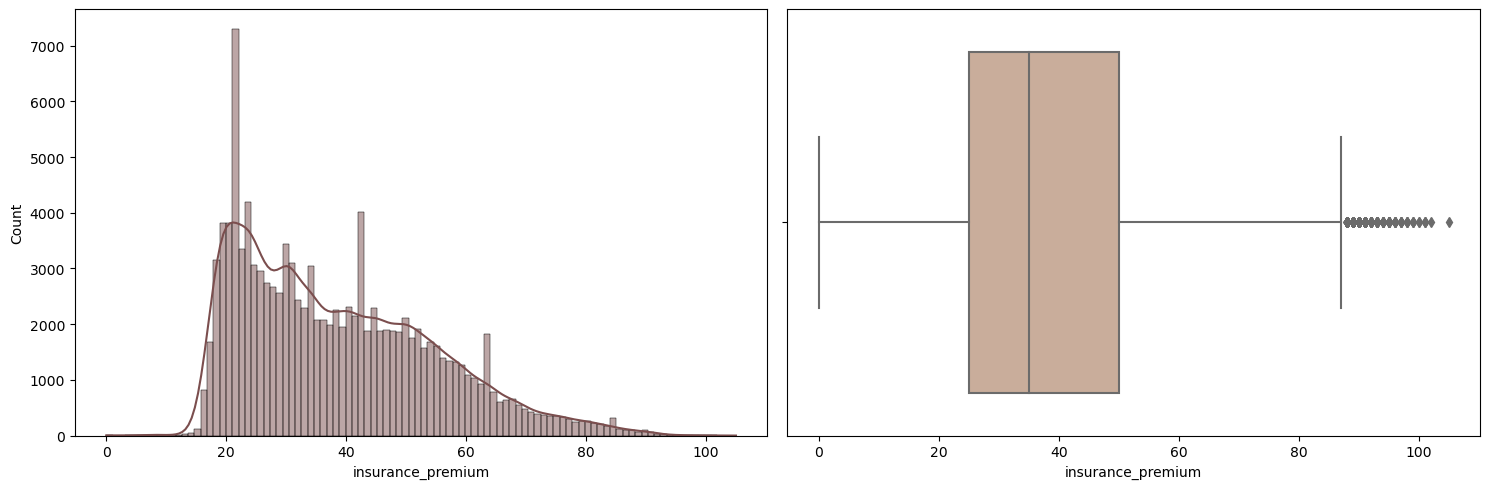

In [77]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['insurance_premium'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['insurance_premium'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [78]:
df['insurance_premium'] = df['insurance_premium'].astype('int8')

Выбросы в данных присутствуют, но их количество сильно меньше, чем значений входяших в распределение, оставим эти данные.

### party_sobriety

Данные о трезвости водителя, может являтся одним из ключевых параметров при обучении, но пропуски объемом в 1.6% можно удалить.

In [79]:
df.loc[df['party_sobriety'].isna() == True]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
22,0,sedan,auto,3,car,37,None,None,NaN,1000.0,...,vehicle code violation,unsafe lane change,hit object,fixed object,dry,normal,daylight,none,morning,winter
35,0,sedan,manual,4,car,35,None,None,0.0,600.0,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none,day,winter
51,1,coupe,auto,5,car,36,None,sleepy/fatigued,0.0,781.0,...,vehicle code violation,unsafe lane change,hit object,fixed object,dry,normal,daylight,none,morning,spring
69,1,sedan,auto,5,car,27,None,None,0.0,1500.0,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,day,spring
315,1,sedan,manual,3,car,21,None,None,0.0,0.0,...,vehicle code violation,automobile right of way,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118245,1,sedan,auto,11,car,80,None,impairment - physical,0.0,281.0,...,vehicle code violation,improper turning,sideswipe,parked motor vehicle,dry,normal,dark with street lights,none,day,spring
118266,1,coupe,manual,6,car,42,None,sleepy/fatigued,0.0,0.0,...,vehicle code violation,traffic signals and signs,hit object,fixed object,dry,normal,dark with no street lights,functioning,evening,spring
118296,1,coupe,auto,6,car,39,None,sleepy/fatigued,0.0,50.0,...,vehicle code violation,improper turning,hit object,fixed object,dry,normal,dark with street lights,none,night,summer
118310,1,coupe,auto,6,car,28,None,under drug influence,NaN,0.0,...,vehicle code violation,dui,broadside,other motor vehicle,dry,normal,daylight,functioning,morning,winter


In [80]:
df = df.loc[df['party_sobriety'].isna() == False]

In [81]:
df['party_sobriety'] = df['party_sobriety'].astype('category')

### party_drug_physical

Состояние участника: физическое или с учётом принятых лекарств так же как и предыдущий потенциально может быть важен для анализа, но объем пропущенных значений черезмерно велик, а существущие записи не репрезентативны для восстановления пропусков, предлагается пробелы заполнить значениями `G` = Impairment Unknown

In [82]:
df.loc[df['party_drug_physical'].isna() == False]

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,distance,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,daylight,season
9,1,sedan,auto,3,car,24,impairment unknown,G,NaN,0.0,...,vehicle code violation,improper turning,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,day,winter
16,1,sedan,auto,3,car,24,impairment unknown,G,0.0,1.0,...,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,dark with no street lights,none,night,winter
28,1,sedan,auto,3,car,24,impairment unknown,G,0.0,1584.0,...,vehicle code violation,improper turning,sideswipe,other motor vehicle,dry,normal,daylight,none,morning,winter
42,1,minivan,manual,7,car,45,impairment unknown,G,NaN,0.0,...,vehicle code violation,automobile right of way,broadside,bicycle,dry,normal,daylight,functioning,morning,spring
45,1,minivan,manual,5,car,34,impairment unknown,G,0.0,175.0,...,vehicle code violation,automobile right of way,broadside,bicycle,dry,normal,daylight,functioning,day,spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118295,0,sedan,auto,3,car,24,impairment unknown,G,0.0,80.0,...,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,none,evening,summer
118336,1,coupe,manual,5,car,21,"had been drinking, under influence",under drug influence,0.0,0.0,...,vehicle code violation,dui,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,night,winter
118337,1,coupe,manual,3,car,21,"had been drinking, under influence",under drug influence,0.0,0.0,...,vehicle code violation,dui,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,night,winter
118357,0,minivan,manual,6,car,40,impairment unknown,G,0.0,0.0,...,vehicle code violation,traffic signals and signs,broadside,bicycle,dry,normal,dark with street lights,functioning,day,winter


In [83]:
df.loc[df['party_drug_physical'].isna() == True, 'party_drug_physical'] = 'G'

In [84]:
df['party_drug_physical'] = df['party_drug_physical'].astype('category')

### cellphone_in_use

Информация о том пользовался ли водитель телефоном или нет, также потенциально очень важна для построения модели, пропуски в данных заполним 0

In [85]:
df.loc[df['cellphone_in_use'].isna() == True, 'cellphone_in_use'] = 0
df['cellphone_in_use'] = df['cellphone_in_use'].astype('int8')

### direction

Восстановить значения направлений движений также не представляется возможным, предлагается перекодировать значения направлений с 1 до 4, а для пустых значений присвоим 0

In [86]:
direction = {'north' : 1, 'east' : 2, 'west': 3, 'south': 4}

df['direction'].replace(direction, inplace=True)

In [87]:
df.loc[df['direction'].isna() == True, 'direction'] = 0
df['direction'] = df['direction'].astype('int8')

### intersection и weather_1

Объем пропусков для каждого признака на уровне 0.3% от общего объема, таким пропуском можно принебречь

In [88]:
df = df.loc[df['intersection'].isna() == False]
df = df.loc[df['weather_1'].isna() == False]

In [89]:
df['intersection'] = df['intersection'].astype('int8')
df['weather_1'] = df['weather_1'].astype('category')

### location_type

Пропуски в типе дороге заполним `other`

In [90]:
df['location_type'] = df['location_type'].fillna('other')
df['location_type'] = df['location_type'].astype('category')


<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Заглушка - вполне адекватный алгоритм обработки пропусков в категориальных колонках

### Пропуски данных менее 1.5%

Для признаков у которых имеются пропуски в данных на уровне менее 1.5% предлагается удалить пропуски.

In [91]:
df = df.loc[df['primary_collision_factor'].isna() == False]
df = df.loc[df['pcf_violation_category'].isna() == False]
df = df.loc[df['type_of_collision'].isna() == False]
df = df.loc[df['motor_vehicle_involved_with'].isna() == False]
df = df.loc[df['road_surface'].isna() == False]
df = df.loc[df['road_condition_1'].isna() == False]
df = df.loc[df['lighting'].isna() == False]
df = df.loc[df['control_device'].isna() == False]
df = df.loc[df['daylight'].isna() == False]

## Преобразование типов данных и удаление дубликатов

Оптимизируем типы данных для признаков

In [92]:
df[['at_fault', 'party_count']] = df[['at_fault', 'party_count']].astype('int8')
df[['vehicle_type', 'party_type','collision_damage','primary_collision_factor',
    'pcf_violation_category','type_of_collision','motor_vehicle_involved_with',
    'road_surface','road_condition_1','lighting','control_device','daylight',
    'season']] = \
    df[['vehicle_type', 'party_type','collision_damage','primary_collision_factor',
    'pcf_violation_category','type_of_collision','motor_vehicle_involved_with',
    'road_surface','road_condition_1','lighting','control_device','daylight',
    'season']].astype('category')

In [93]:
df['distance'] = df['distance'].astype('int16')

Еще раз взглянем на статистику по нашим данным

In [94]:
df.describe()

,at_fault,vehicle_age,insurance_premium,cellphone_in_use,distance,direction,intersection,party_count
count,110472.000000,110472.000000,110472.000000,110472.00000,110472.000000,110472.000000,110472.000000,110472.000000
mean,0.468671,4.874719,38.494632,0.01939,677.314161,1.905243,0.228664,2.358308
std,0.499020,3.096134,16.133074,0.13789,1936.197156,1.471893,0.419974,0.948894
min,0.000000,0.000000,0.000000,0.00000,-31744.000000,0.000000,0.000000,1.000000
25%,0.000000,3.000000,25.000000,0.00000,5.000000,1.000000,0.000000,2.000000
50%,0.000000,4.000000,35.000000,0.00000,125.000000,2.000000,0.000000,2.000000
75%,1.000000,7.000000,50.000000,0.00000,528.000000,3.000000,0.000000,3.000000
max,1.000000,19.000000,105.000000,1.00000,32736.000000,4.000000,1.000000,10.000000


Видно что было упущено аномальное значение для параметра `distance`. Однозначно определить предельно возможное расстояние до главное дороги затруднительно, исходя из анализа статей ([ГОСТ Р 58653-2019](https://files.stroyinf.ru/Data2/1/4293725/4293725783.htm?ysclid=lrupvso19e520973235#i52115) и [Interstate Highway standards](https://translated.turbopages.org/proxy_u/en-ru.ru.3f185375-65b3bd3d-2e88835d-74722d776562/https/en.wikipedia.org/wiki/Interstate_Highway_standards)), можно сделать предположение, что ограничение в два стандартных отклонения может быть решением.

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


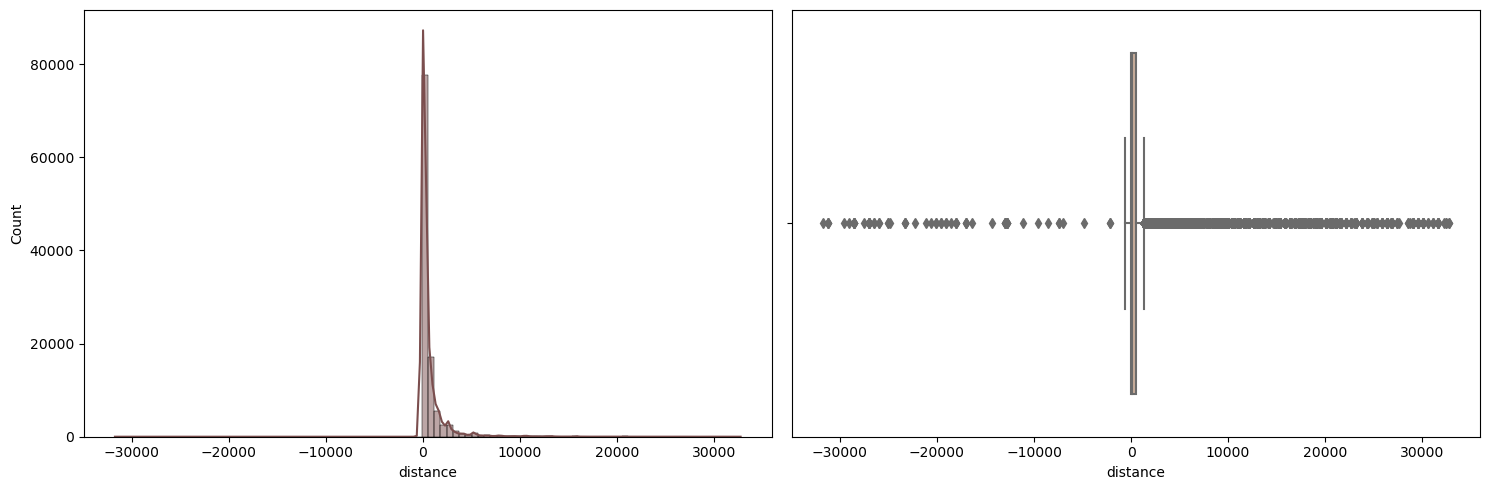

In [95]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['distance'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['distance'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [96]:
df['distance'] = df['distance'].abs()
df = df.loc[df['distance'] < df['distance'].std()]

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


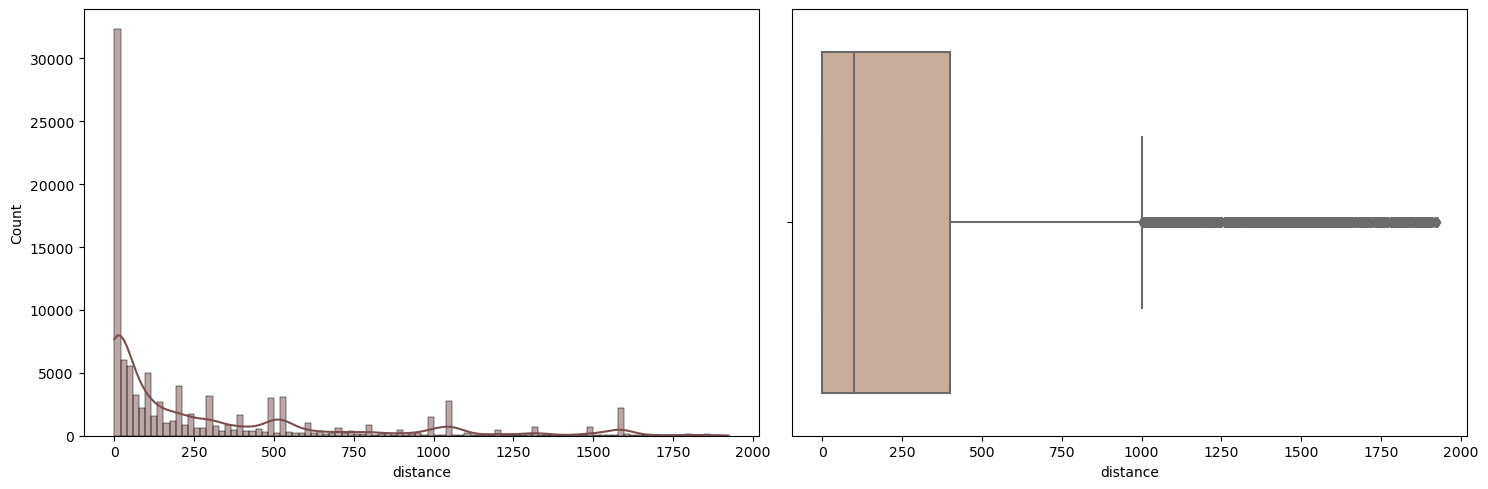

In [97]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['distance'], ax=axes[0], kde=True, bins=100, edgecolor='black', color=sns.color_palette("pink")[0])
sns.boxplot(x=df['distance'], ax=axes[1], orient='h', palette="pink")

plt.tight_layout()
plt.show()

In [98]:
df = df.drop_duplicates().reset_index(drop=True)

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Молодец, что удаляешь дубликаты в конце обработки данных, ведь с момента выгрузки до момента полной обработки число дубликатов может сильно вырасти.

**Выводы**

Подготовлены данные согласно требованию заказчика.

- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.

Также добавлен новый столбец указывающий на время года в которое было совершено ДТП и время суток основанное на значениях времени.

Для большинства данных с пропусками, было выполнено заполнение этих пропусков в зависимости от специфики признака, для данных объем пропуском которых составлял менее 1.5% было принято решение об удалении пустых строк.

# Подготовка признаков и построение базовых моделей

Разобьем данные по соотношению 75:25, создав только две выборки, обучающую и тестовую, так как для оценки качества прогноза моделей будет использована кросс-валидация.

In [100]:
target = df['at_fault']
features = df.drop('at_fault', axis=1)

In [101]:
features_train, features_test, target_train, target_test \
= train_test_split(features, target, test_size = 0.25, random_state = RANDOM_STATE)

<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
3 выборки - подход, безусловно, имеющий право на жизнь, но когда у нас нет на это ограничений, лучше использовать кросс-валидацию. Во-первых, нам не приходится откладывать часть данных для только валидации, а чем больше у нас данных, тем лучше. Во-вторых, метрика на нескольких фолдах кросс-валидации - это более устойчивая оценка качества работы модели, чем на одной отложенной валидационной выборке.

<div class="alert alert-info">
<font size="4"><b> Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
В первых своих итерациях я использовал кросс-валидацию, почему то перед ревь решил, что стоит упроситить этот момент, каюсь и возвращаю все как было 😅
    </font>
</div>

## Кодирование категориальных данных и масштабирование признаков

Предлагается оценить качество прогноза трех моделей, логистической регрессии (LogisticRegression), дерево принятия решений (DecisionTreeClassifier) и модель градиентного бустинга над решющающими деревьями (CatBoost).

Для логистической регрессии и решающего дерева необходимо сделать кодирование данных, а для CatBoost этого делать не нужно, так как самостоятельное кодирование ухудшит результаты прогноза. Будет выполнено прямое кодирование OneHotEncoding.

Данные необходимо отмасштабировать

**OHE**

In [102]:
ohe_features = features.select_dtypes(include='category').columns.to_list()
print(ohe_features)
num_features = features.select_dtypes(exclude='category').columns.to_list()
num_features

['vehicle_type', 'vehicle_transmission', 'party_type', 'party_sobriety', 'party_drug_physical', 'weather_1', 'location_type', 'collision_damage', 'primary_collision_factor', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'daylight', 'season']


['vehicle_age',
 'insurance_premium',
 'cellphone_in_use',
 'distance',
 'direction',
 'intersection',
 'party_count']

In [103]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
features_ohe_train = features_train.copy()

encoder_ohe.fit(features_ohe_train[ohe_features])

transformed = encoder_ohe.transform(features_ohe_train[ohe_features])

ohe_df = pd.DataFrame(transformed, columns = encoder_ohe.get_feature_names_out(), index = features_ohe_train.index)

features_ohe_train = pd.concat([features_ohe_train, ohe_df], axis=1).drop(ohe_features, axis=1)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
        <b></b>

Молодец, что не забыл указать `drop='first'`, тем самым избежал <a href="https://www.codecamp.ru/blog/dummy-variable-trap/">дамми-ловушки</a>.

In [105]:
features_ohe_test = features_test.copy()
transformed = encoder_ohe.transform(features_ohe_test[ohe_features])

ohe_df = pd.DataFrame(transformed, columns = encoder_ohe.get_feature_names_out(), index = features_ohe_test.index)

features_ohe_test = pd.concat([features_ohe_test, ohe_df], axis=1).drop(ohe_features, axis=1)

**Scaler**

In [106]:
scaler = StandardScaler()
scaler.fit(features_ohe_train[num_features])

features_ohe_slr_train = features_ohe_train.copy()
features_ohe_slr_test = features_ohe_test.copy()

features_ohe_slr_train[num_features] = scaler.transform(features_ohe_train[num_features])
features_ohe_slr_test[num_features] = scaler.transform(features_ohe_test[num_features])

## Анализ мультиколлениарности

Для выявления эффекта мультиколлениарности нужно оценить вздутие дисперсии каждого признака, при привышении этого знаечния более чем на 9, признак нужно устранить из выборки

In [107]:
vif_data = pd.DataFrame()
vif_data["feature"] = features_ohe_slr_train.columns

# вычисление VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(features_ohe_slr_train.values, i) \
                          for i in range(len(features_ohe_slr_train.columns))]

print(vif_data)

divide by zero encountered in scalar divide


              feature        VIF
0         vehicle_age   1.199123
1   insurance_premium   1.156753
2    cellphone_in_use   1.005266
3            distance   1.436351
4           direction   2.068000
..                ...        ...
90   daylight_morning   1.714830
91     daylight_night   1.929800
92      season_spring  52.428836
93      season_summer   3.582751
94      season_winter  36.220772

[95 rows x 2 columns]


In [108]:
VIF_features_drop = vif_data.query('VIF > 9.0')['feature']
VIF_features_drop

13    party_sobriety_had been drinking, under influence
14                 party_sobriety_had not been drinking
15                    party_sobriety_impairment unknown
16                        party_sobriety_not applicable
18                   party_drug_physical_not applicable
30                       collision_damage_middle damage
32                        collision_damage_small damage
33      primary_collision_factor_other improper driving
34           primary_collision_factor_other than driver
35                     primary_collision_factor_unknown
36      primary_collision_factor_vehicle code violation
48        pcf_violation_category_other improper driving
49    pcf_violation_category_other than driver (or p...
54                       pcf_violation_category_unknown
64                  motor_vehicle_involved_with_bicycle
65             motor_vehicle_involved_with_fixed object
67            motor_vehicle_involved_with_non-collision
68      motor_vehicle_involved_with_other motor 

In [109]:
features_ohe_slr_train = features_ohe_slr_train.drop(VIF_features_drop.values, axis=1)
features_ohe_slr_test = features_ohe_slr_test.drop(VIF_features_drop.values, axis=1)

## Baseline

Выбранные модели будут оцениваться по нескольким показателям: время обучения модели, время прогназирование модели, матрица ошибок, значение метрики F1 и площади под ROC-кривой.

In [332]:
def metrics(target, prediction, prediction_proba):
    print("F-beta:",fbeta_score(target,prediction,average='macro',beta=2))
    print("AUC-ROC:", roc_auc_score(target, prediction_proba[:, 1]))
    
    fpr, tpr, thresholds = roc_curve(target, prediction_proba[:, 1])
    cm_matrix = pd.DataFrame(data=confusion_matrix(target, prediction), 
                                columns=['Actual Positive:1', 'Actual Negative:0'], 
                                index=['Predict Positive:1', 'Predict Negative:0'])
    tp = cm_matrix['Actual Positive:1']['Predict Positive:1']
    fp = cm_matrix['Actual Positive:1']['Predict Negative:0']
    fn = cm_matrix['Actual Negative:0']['Predict Positive:1']
    tn = cm_matrix['Actual Negative:0']['Predict Negative:0']
    print('Precision =', round(tp / (tp + fp), 3))
    print('Recall = ', round(tp / (tp + fn), 3))

    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

    sns.heatmap(cm_matrix, annot=True, fmt='d', 
                cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=axes[0])
    axes[1].plot([0, 1], [0, 1], linestyle='--')
    axes[1].plot(fpr, tpr)


    axes[0].title.set_text('Матрица ошибок')
    axes[1].title.set_text('ROC-кривая')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.tight_layout()
    plt.show()

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Недостатком метрики F1 является то, что для неё точность и полнота равнозначны, а в нашем проекте это не так. Низкая точность снизит наше доверие к водителям, из-за чего мы можем потерять их лояльность. Низкая полнота - угроза здоровью и жизни людей. Второе важнее. Поэтому есть смысл взять <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html">F-beta</a> меру с уклоном на полноту (beta=2, например)

<div class="alert alert-info">
<font size="4"><b> Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Точно, почему то не пришло в голову сразу
    </font>
</div>

### LogisticRegression

In [336]:
model_lr = LogisticRegression(random_state = RANDOM_STATE, solver='liblinear')

start_time_lr = time()

model_lr.fit(features_ohe_slr_train, target_train)

end_time_lr = time()

lr_model_time_fit = (end_time_lr-start_time_lr) / 60

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Как-то несколько удивительно, что сначала ты делаешь вывод, что сильного дисбаланса нет, а потом применяешь методы борьбы с дисбалансом, такие как стратификация разбиения на выборки и взвешивание классов.
    </font>
</div>

<div class="alert alert-info">
<font size="4"><b> Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Ну да, не логично. Убрал
    </font>
</div>

In [337]:
print('Время обучение модели: {0:.5f} сек.'. format(lr_model_time_fit))

Время обучение модели: 0.01009 сек.


In [338]:
start_time_lr = time()
predicted = model_lr.predict(features_ohe_slr_train)
end_time_lr = time()

lr_model_time_predict = (end_time_lr-start_time_lr) / 60

In [339]:
print('Время прогнозирования модели: {0:.5f} сек.'. format(lr_model_time_predict))

Время прогнозирования модели: 0.00025 сек.


In [340]:
start_time_lr = time()
folds = KFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)
scores_lr = cross_val_score(model_lr, features_ohe_slr_train, target_train, scoring='f1_macro', cv=4)
end_time_lr = time()

lr_model_time_cv = (end_time_lr-start_time_lr) / 60

In [341]:
f_macro_lr = scores_lr.max()
print("F-beta кросс валидации: {0:.4f}.". format(f_macro_lr))

F-beta кросс валидации: 0.6261.


### Decision Tree

In [342]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

start_time_dt = time()

model_dt.fit(features_ohe_slr_train, target_train)

end_time_dt = time()

dt_model_time_fit = (end_time_dt-start_time_dt) / 60

In [343]:
print('Время обучение модели: {0:.5f} сек.'. format(dt_model_time_fit))

Время обучение модели: 0.01280 сек.


In [344]:
start_time_dt = time()
predicted = model_dt.predict(features_ohe_slr_train)
end_time_dt = time()

dt_model_time_predict = (end_time_dt-start_time_dt) / 60

In [345]:
print('Время прогнозирования модели: {0:.5f} сек.'. format(dt_model_time_predict))

Время прогнозирования модели: 0.00050 сек.


In [346]:
start_time_dt = time()
scores_dt = cross_val_score(model_dt, features_ohe_slr_train, target_train, scoring='f1_macro', cv=4)
end_time_dt = time()

dt_model_time_cv = (end_time_dt-start_time_dt) / 60

In [347]:
f_macro_dt = scores_dt.max()
print("F-beta кросс валидации: {0:.4f}.". format(f_macro_dt))

F-beta кросс валидации: 0.6156.


### CatBoost

In [348]:
cat_features = features_train.select_dtypes(include='category').columns.to_list()

In [349]:
start_time_cat = time()
cat_model = CatBoostClassifier(iterations=10000,
                              loss_function='Logloss',
                              eval_metric='F:beta=2',
                              random_state=RANDOM_STATE,
                              task_type="GPU",
                              cat_features=cat_features,
                              early_stopping_rounds=100,
                              ).fit(features_train, target_train,
                                    plot=True, verbose=True)
end_time_cat = time()

cat_model_time_fit = (end_time_cat-start_time_cat) / 60

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.003381


Default metric period is 5 because F is/are not implemented for GPU
Metric F:beta=2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.4919067	total: 32.9ms	remaining: 5m 29s
1:	total: 65.7ms	remaining: 5m 28s
2:	total: 99.1ms	remaining: 5m 30s
3:	total: 130ms	remaining: 5m 25s
4:	total: 164ms	remaining: 5m 28s
5:	learn: 0.5017055	total: 198ms	remaining: 5m 29s
6:	total: 236ms	remaining: 5m 36s
7:	total: 294ms	remaining: 6m 6s
8:	total: 326ms	remaining: 6m 1s
9:	total: 357ms	remaining: 5m 56s
10:	learn: 0.5026127	total: 392ms	remaining: 5m 55s
11:	total: 424ms	remaining: 5m 53s
12:	total: 458ms	remaining: 5m 52s
13:	total: 491ms	remaining: 5m 50s
14:	total: 523ms	remaining: 5m 48s
15:	learn: 0.5020848	total: 556ms	remaining: 5m 46s
16:	total: 586ms	remaining: 5m 44s
17:	total: 624ms	remaining: 5m 45s
18:	total: 657ms	remaining: 5m 44s
19:	total: 689ms	remaining: 5m 43s
20:	learn: 0.5020784	total: 724ms	remaining: 5m 44s
21:	total: 757ms	remaining: 5m 43s
22:	total: 790ms	remaining: 5m 42s
23:	total: 824ms	remaining: 5m 42s
24:	total: 854ms	remaining: 5m 40s
25:	learn: 0.5020848	total: 895ms	remaining: 5m 4

In [350]:
print('Время обучение модели: {0:.5f} сек.'. format(cat_model_time_fit))

Время обучение модели: 5.92633 сек.


In [351]:
start_time_lr = time()
predicted = cat_model.predict(features_train)
end_time_lr = time()

cat_model_time_predict = (end_time_lr-start_time_lr) / 60

In [352]:
print('Время прогнозирования модели: {0:.5f} сек.'. format(cat_model_time_predict))

Время прогнозирования модели: 0.00582 сек.


In [353]:
cv_params = cat_model.get_params()
cv_data = cv(
    Pool(features_train, target_train, cat_features),
    cv_params,
    plot=True, verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because F is/are not implemented for GPU
Metric F:beta=2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


Training on fold [0/3]
bestTest = 0.5910584413
bestIteration = 974
Training on fold [1/3]


Metric F:beta=2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.5842353594
bestIteration = 500
Training on fold [2/3]


Metric F:beta=2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


bestTest = 0.5868483829
bestIteration = 676


In [354]:
f_macro_cb = np.max(cv_data['test-F:beta=2-mean'])
print("F-beta кросс валидации: {0:.4f}.". format(f_macro_cb))

F-beta кросс валидации: 0.5871.


**Выводы**

Были рассмотрены три модели `LogisticRegression`, `DecisionTreeClassifier` и `CatBoostClassifier`.

По значению метрики F-beta лучшей моделью можно признать логистическую регрессию, но сравнивнив данные о матрице ошибок и AUC-ROC на тренировочных данных была выбрана модель CatBoost.

In [355]:
results = {
    'Model' : ['LogisticRegression', 'DecisionTreeClassifier', 'CatBoostClassifier'],
    'Time Fit, sec' : pd.Series([lr_model_time_fit, dt_model_time_fit, cat_model_time_fit]),
    'Time Pred' :pd.Series([lr_model_time_predict, dt_model_time_predict, cat_model_time_predict]),
    'F-beta' :pd.Series([f_macro_lr, f_macro_dt, f_macro_cb])
    }
display(pd.DataFrame(results))

,Model,"Time Fit, sec",Time Pred,F-beta
0,LogisticRegression,0.010092,0.000250,0.626100
1,DecisionTreeClassifier,0.012798,0.000500,0.615583
2,CatBoostClassifier,5.926326,0.005819,0.587120


F-beta: 0.6240188641484787
AUC-ROC: 0.6864351217970819
Precision = 0.633
Recall =  0.751


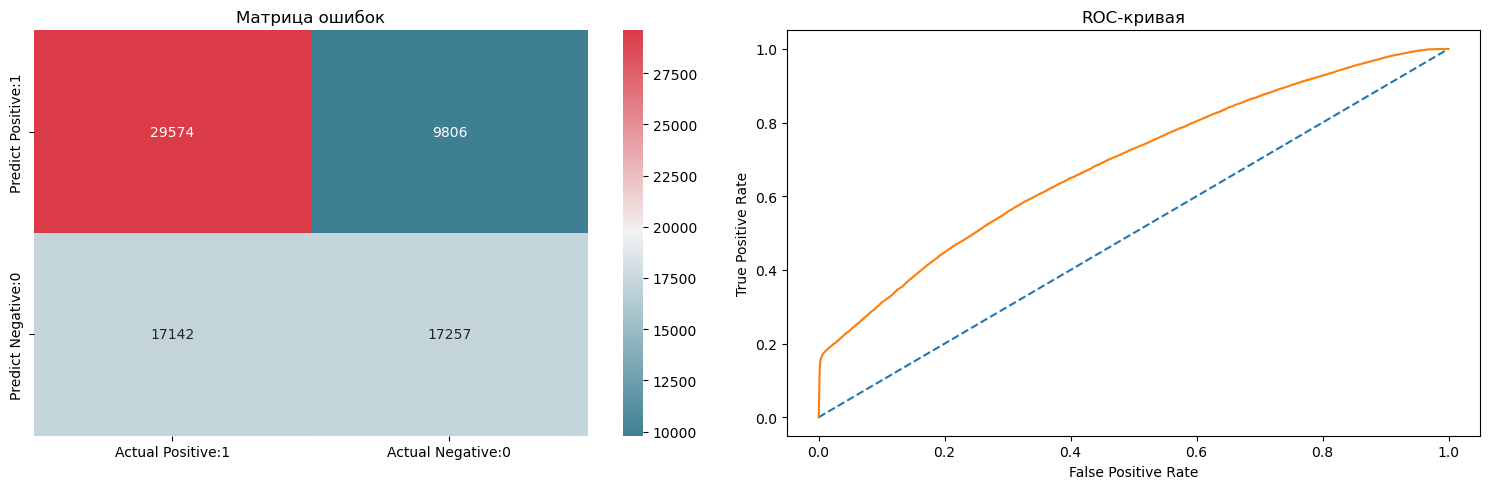

In [356]:
metrics(target_train, model_lr.predict(features_ohe_slr_train), model_lr.predict_proba(features_ohe_slr_train))

F-beta: 0.9849791712080094
AUC-ROC: 0.9995830260606009
Precision = 0.975
Recall =  0.999


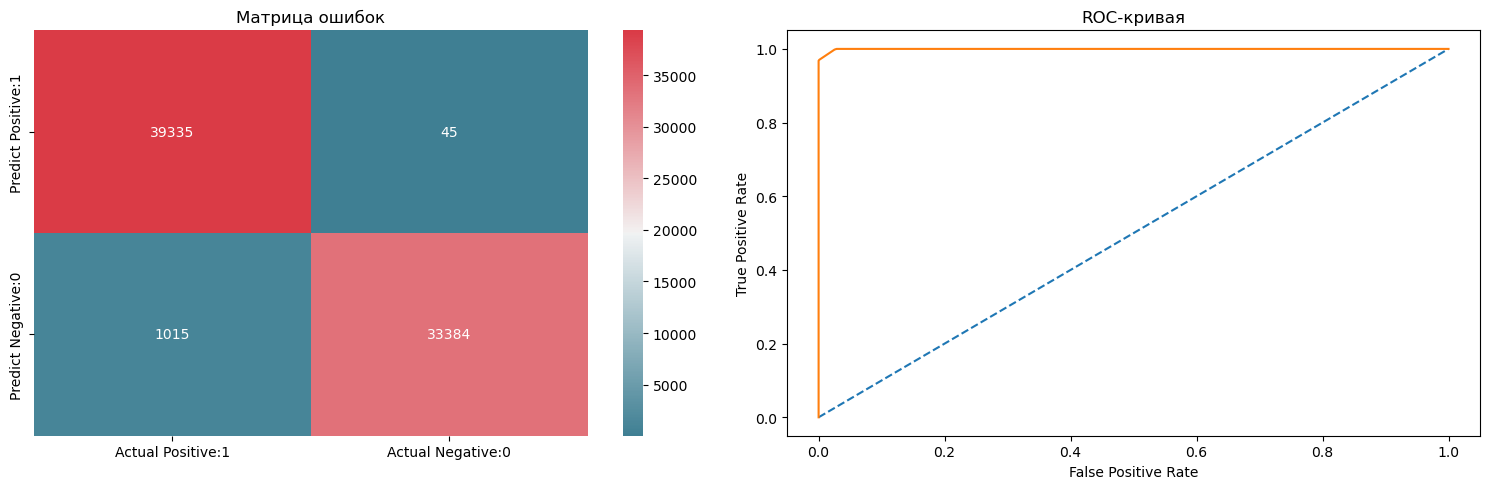

In [357]:
metrics(target_train, model_dt.predict(features_ohe_slr_train), model_dt.predict_proba(features_ohe_slr_train))

F-beta: 0.7145186750721344
AUC-ROC: 0.8111915871330486
Precision = 0.699
Recall =  0.859


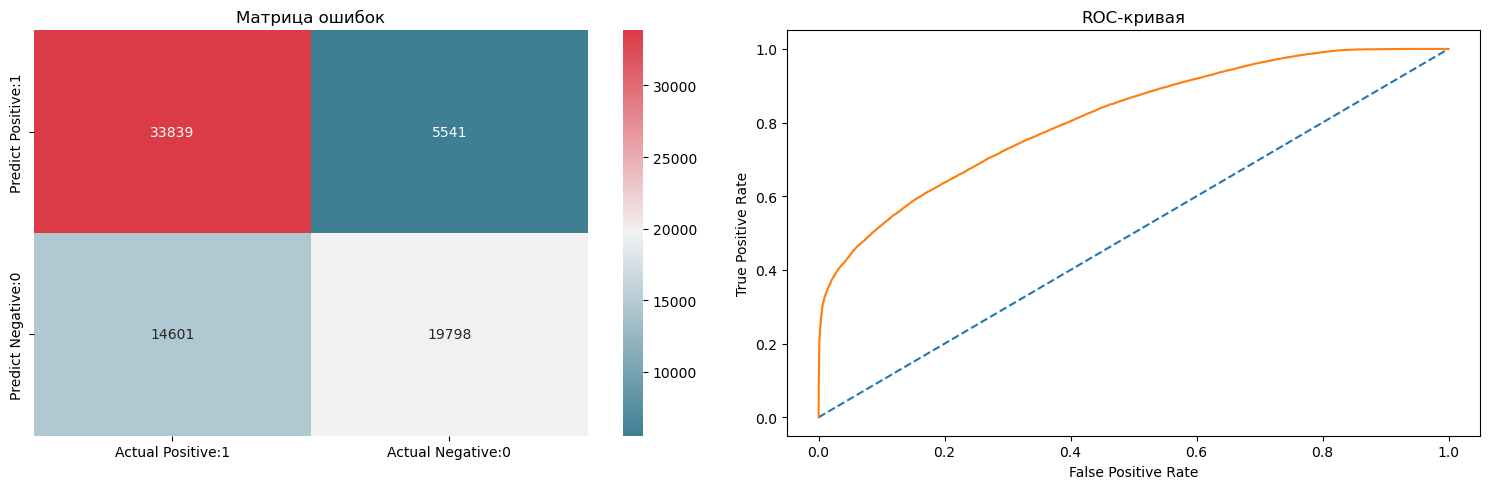

In [358]:
metrics(target_train, cat_model.predict(features_train), cat_model.predict_proba(features_train))

<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Это не очень правильно, а вернее совсем неправильно, когда о том, какая модель лучше, ты судишь по качеству на гиперпараметрах по умолчанию, либо вбитых "наобум". Гипотетически ведь вполне возможна ситуация, что с качественно подобранными гиперпараметрами дерево покажет результат лучше, чем бустинг (хоть это и очень маловероятно).

# Оптимизация гипперпараметров и обучение лучшей модели

Воспользуемся библиотекой optuna для подбора оптимальных гипперпараметров для обучения финальной модели

In [310]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),
        "depth": trial.suggest_int("depth", 5, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 100),
        "task_type":"GPU",
        'early_stopping_rounds': 100
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(features_train, target_train, cat_features)
    predictions = model.predict(features_train)
    fb = fbeta_score(target_train,predictions,average='macro',beta=2)
    return fb

In [312]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

[I 2024-02-02 13:05:29,272] A new study created in memory with name: no-name-2e4f0e3d-5321-4b9c-be9f-9f1103c02a14
[I 2024-02-02 13:06:01,751] Trial 0 finished with value: 0.7034560498185132 and parameters: {'learning_rate': 0.0106771833151165, 'depth': 5, 'min_data_in_leaf': 57}. Best is trial 0 with value: 0.7034560498185132.
[I 2024-02-02 13:07:40,659] Trial 1 finished with value: 0.7337355687776153 and parameters: {'learning_rate': 0.02046162435680076, 'depth': 10, 'min_data_in_leaf': 78}. Best is trial 1 with value: 0.7337355687776153.
[I 2024-02-02 13:08:53,475] Trial 2 finished with value: 0.747378205160818 and parameters: {'learning_rate': 0.04950810725154942, 'depth': 9, 'min_data_in_leaf': 89}. Best is trial 2 with value: 0.747378205160818.
[I 2024-02-02 13:09:50,231] Trial 3 finished with value: 0.7217653177491434 and parameters: {'learning_rate': 0.026157786476048446, 'depth': 8, 'min_data_in_leaf': 67}. Best is trial 2 with value: 0.747378205160818.
[I 2024-02-02 13:10:24,2

In [313]:
print('Best hyperparameters:', study.best_params)
print('Best F1:', study.best_value)

Best hyperparameters: {'learning_rate': 0.09804545640733539, 'depth': 10, 'min_data_in_leaf': 89}
Best F1: 0.7995244047818627


In [314]:
params_opt = {'learning_rate': 0.09804545640733539, 'depth': 10, 'min_data_in_leaf': 89}

In [359]:
cv_params = cat_model.get_params()
# cv_params.update(study.best_params)
cv_params.update(params_opt)

cat_model = CatBoostClassifier(**cv_params).fit(features_train, target_train,
                                            plot=True, verbose=True,
                                            eval_set=(features_train, target_train))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because F is/are not implemented for GPU
Metric F:beta=2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.5216023	test: 0.5220612	best: 0.5220612 (0)	total: 99.1ms	remaining: 16m 30s
1:	total: 195ms	remaining: 16m 12s
2:	total: 286ms	remaining: 15m 52s
3:	total: 372ms	remaining: 15m 30s
4:	total: 462ms	remaining: 15m 22s
5:	learn: 0.5549089	test: 0.5538630	best: 0.5586134 (1)	total: 556ms	remaining: 15m 26s
6:	total: 651ms	remaining: 15m 29s
7:	total: 746ms	remaining: 15m 31s
8:	total: 839ms	remaining: 15m 31s
9:	total: 925ms	remaining: 15m 24s
10:	learn: 0.5566437	test: 0.5526314	best: 0.5586134 (1)	total: 1.02s	remaining: 15m 30s
11:	total: 1.12s	remaining: 15m 30s
12:	total: 1.21s	remaining: 15m 29s
13:	total: 1.3s	remaining: 15m 29s
14:	total: 1.39s	remaining: 15m 28s
15:	learn: 0.5755039	test: 0.5725252	best: 0.5725252 (15)	total: 1.48s	remaining: 15m 25s
16:	total: 1.58s	remaining: 15m 28s
17:	total: 1.67s	remaining: 15m 26s
18:	total: 1.76s	remaining: 15m 24s
19:	total: 1.87s	remaining: 15m 34s
20:	learn: 0.5815176	test: 0.5793983	best: 0.5793983 (20)	total: 1.97s	remain

F-beta: 0.6785400298629578
AUC-ROC: 0.765953550209181
Precision = 0.681
Recall =  0.769


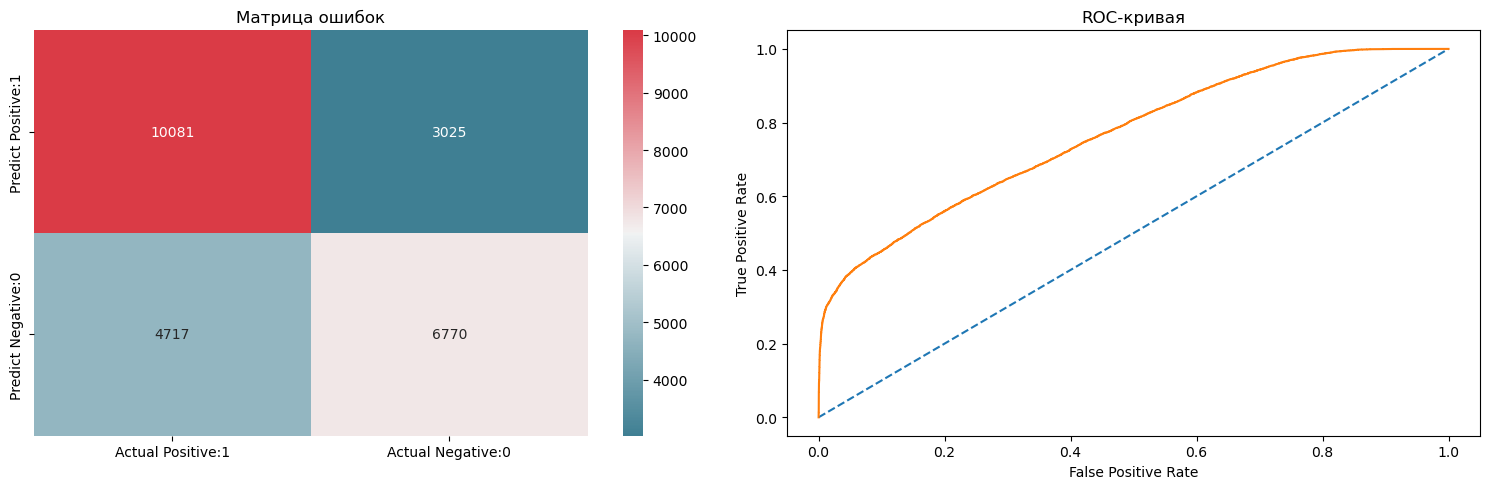

In [360]:
metrics(target_test, cat_model.predict(features_test), cat_model.predict_proba(features_test))

**Выводы**

По результатам обучения модели с оптимизированными гипперпараметрами, удалось добиться значений метрик на тестовой выборке


- F-beta 0.676
- AUC-ROC 0.764
- Precision 0.681
- Recall 0.769

# Важность признаков

Из результатов обучения модели CatBoost оценим, какие признаки по мнению модели были наиболее значимыми.

In [318]:
features_imp = cat_model.get_feature_importance(prettified=True)
features_imp

,Feature Id,Importances
0,insurance_premium,15.463561
1,distance,9.385099
2,vehicle_age,8.231846
3,pcf_violation_category,7.845618
4,party_count,6.218428
5,daylight,6.073084
6,type_of_collision,5.967971
7,location_type,5.579758
8,season,5.376107
9,direction,4.858825


In [319]:
explainer = shap.TreeExplainer(cat_model)
shap_values=explainer.shap_values(Pool(features_train, target_train, cat_features=cat_features))

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3,:], features_train.iloc[3,:])

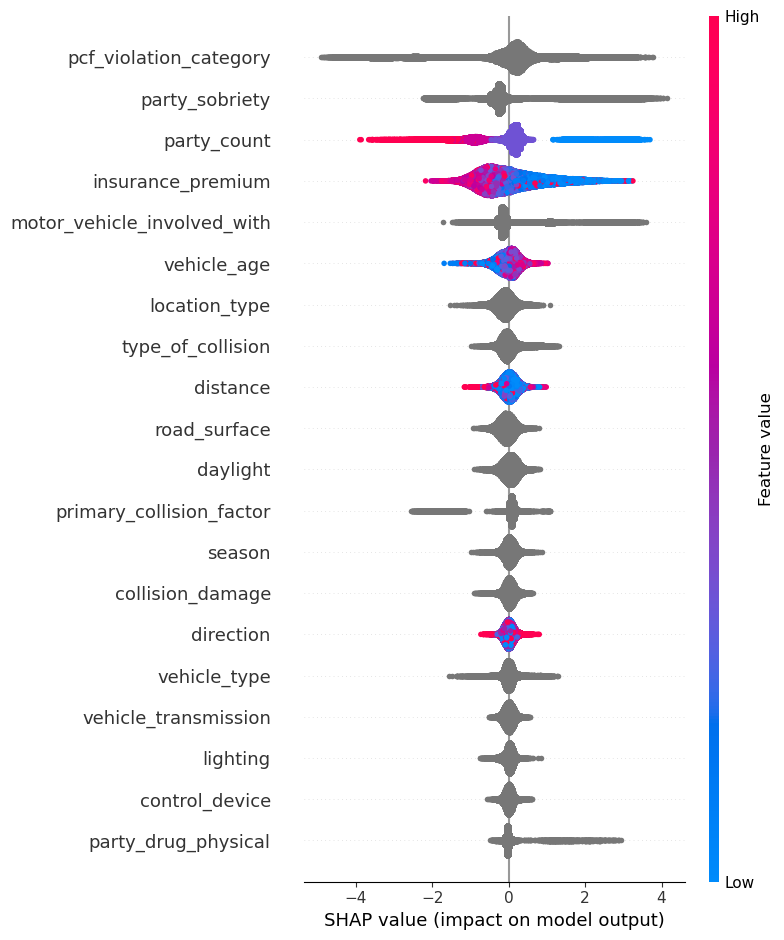

In [320]:
shap.summary_plot(shap_values, features_train)

Из всех возможных признаков в топ-3 модель выделила: количество участников проишествия, категория нарушения и трезвость участника ДТП. Рассмотрим корреляционную связь с ДТП на примере трезвости участника, для первых 500 прогнозов

In [321]:
features_train_small = features_train.iloc[0:500]
shap_small = shap_values[:500]
shap.force_plot(explainer.expected_value, shap_small, features_train_small)

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Важность признаков проанализирована 👍

Как можно видеть из графика, на результат работы модели сильно влиял факт того находится ли участник движение в трезвом состоянии.

Тоже самое можно сказать и о количестве участнимков нарушений, где при значении 1, очевидно прогнозируется, что водитель виновен и чаще не виновен если участников больше 2.

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Oписание проекта говорит в том числе:

1. Проведите графический анализ «Матрица ошибок». Выведите полноту и точность на график.

Не вижу в твоей работе ни первого, ни второго. Добавь, пожалуйста матрицу ошибок и <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html">кривую тoчнocти-пoлнoты</a>.

**ВАЖНО**: обрати внимание, что кривая точности полноты строится по предсказанным вероятностям класса 1, а не по предсказанным классам. Это логично, ведь точность и полнота зависят от порога классификации, а если на вычисление подать список из 0 и 1, то изменение порога ничего в классификации не изменит.

<div class="alert alert-info">
<font size="4"><b> Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Готово!
    </font>
</div>

F-beta: 0.6785400298629578
AUC-ROC: 0.765953550209181
Precision = 0.681
Recall =  0.769


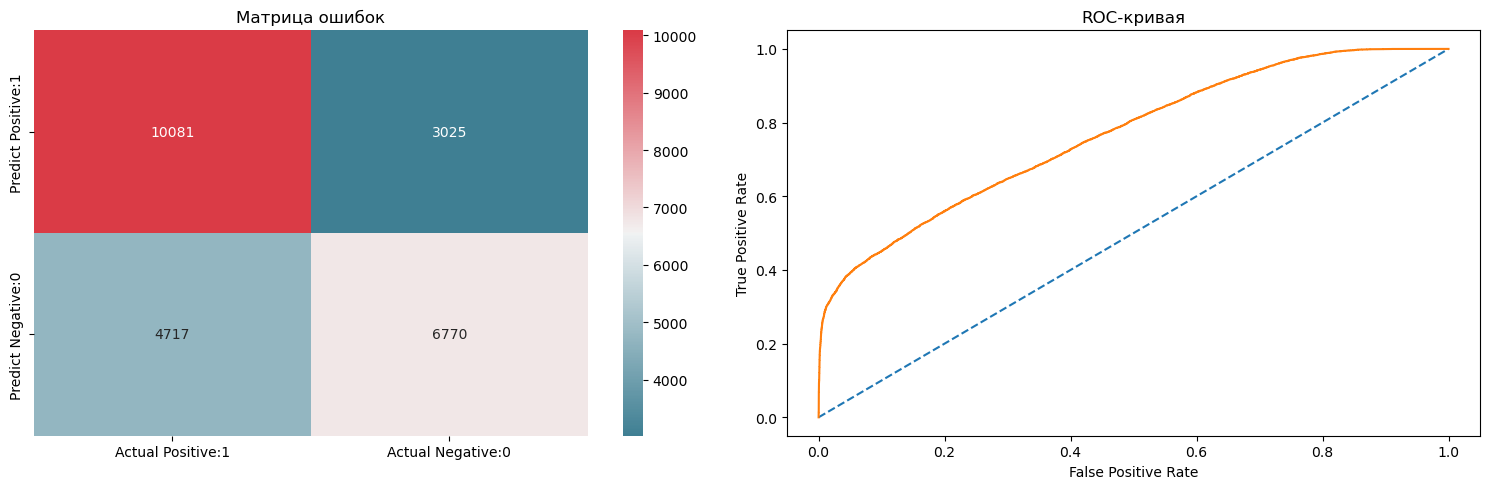

In [361]:
metrics(target_test, cat_model.predict(features_test), cat_model.predict_proba(features_test))

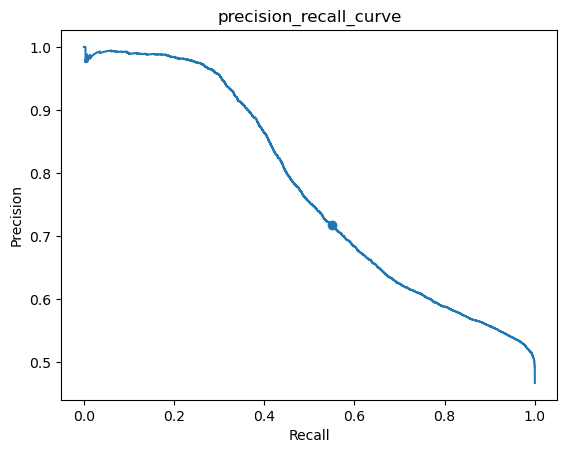

In [372]:
fpr, tpr, thresholds = roc_curve(target_test, cat_model.predict_proba(features_test)[:, 1])

precision, recall, _ = precision_recall_curve(target_test, cat_model.predict_proba(features_test)[:, 1])

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.scatter(recall_score(target_test, cat_model.predict_proba(features_test)[:, 1]>=thresholds[np.argmax(tpr - fpr)]),
            precision_score(target_test, cat_model.predict_proba(features_test)[:, 1]>=thresholds[np.argmax(tpr - fpr)]))
plt.title("precision_recall_curve")
plt.show()

**Вывод**


Из полученных результатов можно сделать вывод, что модель на основе градиентного бустинга CatBoost хорошо предсказывает и Positive и Negative классы. Так же модель больше ошибается при прогнозировании позитивного класса, чем негативного.

# Заключение

Целью проекта было создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Заказчику было важно:

- тип виновника — только машина (car);
- любым повреждениям транспортного средства, кроме типа SCRATCH (царапина);
- ограничиться данными за 2012 год — они самые свежие;
- учесть фактор возраста автомобиля.

Выполненые задачи:
- Первичный анализ таблиц;
- Cтатистический анализ факторов ДТП;
- Оценка водительского риска и EDA;
- Подготовка признаков и построение базовых моделей;
- Оптимизация гипперпараметров и обучение лучшей модели;
- Важность признаков.

**Первичный анализ таблиц**

Количество таблиц сопадало с заявленым, однако во всех таблицах имелись пропуски в данных и типы данных не соответсвовали заявленым. Связующая таблица case_ids не соответствовала завяленой архитектуре. Записи в таблицах `collisions` и `parties` несогласовались с описанием таблиц. Связующая таблица в столбце `db_year` содержит только одно уникальное значение 2021 года, что он означает не известно, но скорее всего это год создания схемы.

В данных содержится информация связанная исключительно с ДТП, но нет данных которые бы относились к благоприятной поездки, при обучении модель будет всегда смещаться в сторону ДТП из-за дисбаланса.

Общий ключ для всех таблиц - case_id

**Cтатистический анализ факторов ДТП**

Наиболее опасными сезонами является весна и зима, это можно связать с сильным изменением погодных условий, таких как: температура, давление, количество осадков, скорость ветра. Можно предположить, что все эти параметры влияют на дорожное покрытие и видимость для автомобилиста, что повишает риск ДТП, что и видно на гистрограмме.

Для команды аналитиков были подготовлены аналитические задачи:
- Определить распределение участников проишествия по типу;
- Определить корреляцию между основным фактором аварии и суммой страховки;
- Существует ли зависимость параметров автомобиля с суммой страховки;
- Есть ли связь с состоянием дороги и временем года;
- Оценить взудите диссперсии параметров в таблице "информация о происшествиях", существуют ли линейно дублирующие параметры в таблице;
- Оценить серьезность ущерба в зависимости от трезвости водителя.

Преведены примеры решения некоторых из них, по результатам которых стало ясно, что:

- Наиболее опасными сезонами является весна и зима, это можно связать с сильным изменением погодных условий, таких как: температура, давление, количество осадков, скорость ветра. Можно предположить, что все эти параметры влияют на дорожное покрытие и видимость для автомобилиста, что повишает риск ДТП, что и видно на гистрограмме.
- Наиболее частым участником проишествия является другой автомобиль, на втором месте дорожные знаки.
- Из анализа коррелляции и статистической значимости, можно сказать, что размер страховки не полностью, но в том числе зависит от типа кузова автомобиля, анализ показал, что по количеству аварий лидирующие позиции занимают тип кузова купе и седан они же имеют самые большие страховые взносы.

**Оценка водительского риска и EDA**

Подготовлены данные согласно требованию заказчика.

- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.

Также добавлен новый столбец указывающий на время года в которое было совершено ДТП и время суток основанное на значениях времени.

Для большинства данных с пропусками, было выполнено заполнение этих пропусков в зависимости от специфики признака, для данных объем пропуском которых составлял менее 1.5% было принято решение об удалении пустых строк.

**Подготовка признаков и построение базовых моделей**

Были рассмотрены три модели `LogisticRegression`, `DecisionTreeClassifier` и `CatBoostClassifier`.
Для первых двух моделей данные были энкодированы технологией OHE и выполнено масштабирование, для CatBoost это делать не нужно, по инструкции разработчиков.
Выбранные модели оценивались по нескольким показателям: время обучения модели, время прогназирование модели, матрица ошибок, значение метрики F1 и площади под ROC-кривой.

По результатам метрик из таблицы была выбрана модель CatBoost.


In [370]:
display(pd.DataFrame(results))

,Model,"Time Fit, sec",Time Pred,F-beta
0,LogisticRegression,0.010092,0.000250,0.626100
1,DecisionTreeClassifier,0.012798,0.000500,0.615583
2,CatBoostClassifier,5.926326,0.005819,0.587120


**Оптимизация гипперпараметров и обучение лучшей модели**

Для оптимизации гипперпараметров использовалась библиотека optuna. По результатам обучения модели с новыми гипперпараметрами удалось добиться на тестовой выборке значений 


F-beta: 0.6785400298629578
AUC-ROC: 0.765953550209181
Precision = 0.681
Recall =  0.769


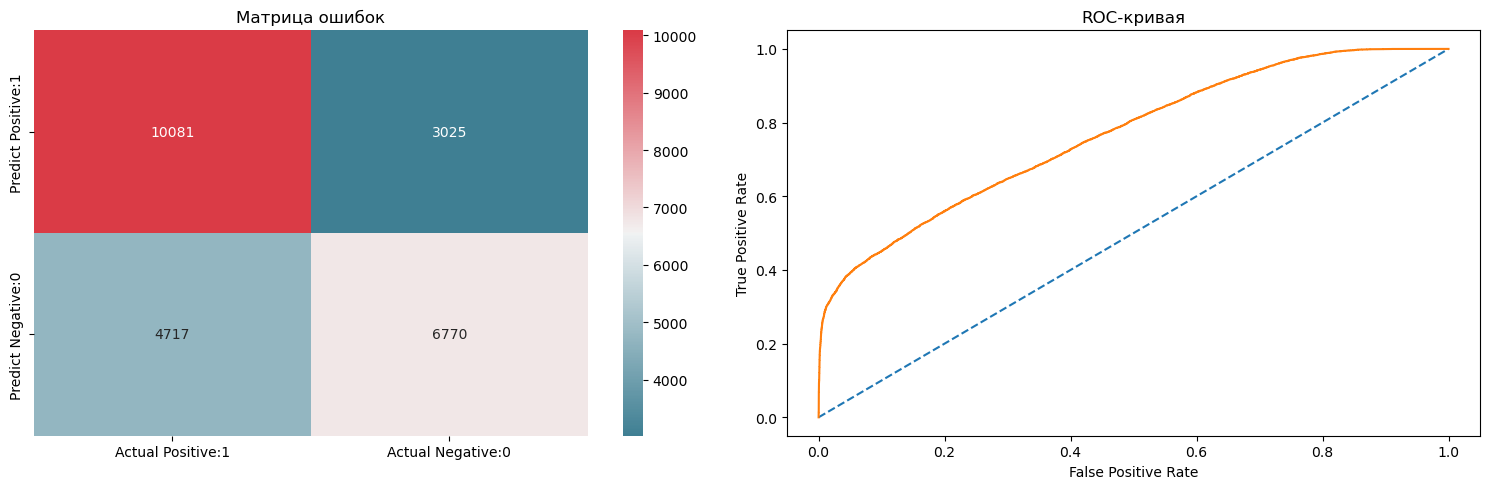

Recall 0.5502742230347349
Precision 0.7179691049522944


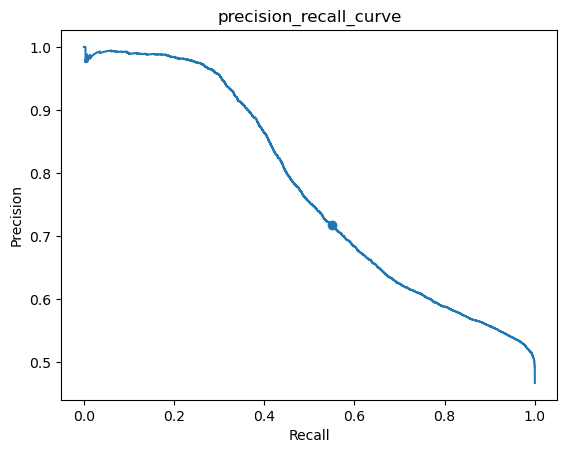

In [371]:
metrics(target_test, cat_model.predict(features_test), cat_model.predict_proba(features_test))


fpr, tpr, thresholds = roc_curve(target_test, cat_model.predict_proba(features_test)[:, 1])

print('Recall', recall_score(target_test, cat_model.predict_proba(features_test)[:, 1]>=thresholds[np.argmax(tpr - fpr)]))
print('Precision', precision_score(target_test, cat_model.predict_proba(features_test)[:, 1]>=thresholds[np.argmax(tpr - fpr)]))

precision, recall, _ = precision_recall_curve(target_test, cat_model.predict_proba(features_test)[:, 1])

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.scatter(recall_score(target_test, cat_model.predict_proba(features_test)[:, 1]>=thresholds[np.argmax(tpr - fpr)]),
            precision_score(target_test, cat_model.predict_proba(features_test)[:, 1]>=thresholds[np.argmax(tpr - fpr)]))
plt.title("precision_recall_curve")
plt.show()


**Важность признаков**

Из всех возможных признаков в топ-3 модель выделила: количество участников проишествия, категория нарушения и трезвость участника ДТП.


**Заключение**

На основании предоставленных данных невозможно построение системы оценки риска ДТП. Данные отображают только одну категорию - "Водители попавшие в ДТП", второй категории - "Водители не попавшие в ДТП" нет совсем. Наша сисетма обучаясь на данных в которых 100% дисбаланс классов учится предказывать, что все поездки закончатся ДТП.


<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Соглашусь по поводу заключения. Это весьма серьёзное логическое упущение в проекте.

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
        <b></b>

Пришло время подвести итоги. В целом, твоя работа оставила весьма благоприятное впечатление, но парочка причин для доработки есть:

+ Исправить исследование временных характеристик аварий, убрав из рассмотрения в нём "неполноценный" 2012 год
+ Добавить графическое исследование лучшей модели: матрицу ошибок и кривую точности-полноты

На этом пока всё. Жду новую отправку от тебя.

<div class="alert alert-info">
<font size="4"><b> Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
Никита, спасибо за твое ревью, оно помогло мне победить зло, а не примкнуть к нему, спасибо за твои замечания и советы!
    </font>
</div>